In [1]:
# packages
import numpy as np
import pandas as pd
import os
import sys
sys.path.append(os.path.dirname(os.getcwd()) + '/source')
import pickle
from solver_1d import false_transient_one_iteration_python
from supportfunctions import PDESolver_2d, finiteDiff
from numba import njit
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import bicg
from derivative import derivatives_2d, derivative_1d
import SolveLinSys
import time
from solver_ode import solve_ode, solve_ode_one
from solver_jump import approach_one_100, solve_smooth_unreveal, generate_weight, solve_smooth_100
from scipy import interpolate
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

In [306]:
# parameters
δ = 0.01
η = 0.032
μ = 1.86/1000
θ_list = pd.read_csv("../data/model144.csv", header=None)[0].to_numpy()
θ_list = θ_list/1000
σy = 1.2*np.mean(θ_list)
ς = 0.1
# damage function
# ȳ = 1.9
γ1 = 0.00017675
γ2 = 2*0.0022
γ3_list = np.linspace(0, 1/3,40)
# capital parameters
invkap = 0.09
α = 0.115
αₖ = - 0.043
σₖ = 0.0085
κ = 6.667
k0 = 80/α

In [3]:
# γ3_list_test = γ3_list[[0,1,2,-1]]
# γ3_list = γ3_list_test

In [4]:
n_temp = 16
n_carb = 9
n_θ = len(θ_list)
θ_mat = θ_list.reshape(n_temp, n_carb)
θtemp_list = np.average(θ_mat, axis=1)
θcarb_list = np.average(θ_mat, axis=0)

In [5]:
from multiprocessing import Pool
ξa = 0.01
ξw = 100000
ξp = 5
dmg_weight = np.ones(len(γ3_list))/len(γ3_list)

hy = 0.02
y_bar =2
y_min = 0
y_max = 4
y_lower = 1.5

jump_interval = np.arange(y_lower,y_bar+hy, hy)
y_grid = np.arange(y_min, y_max+hy, hy)

In [6]:
args_low = (δ, η, θ_list, σy, γ1, γ2, γ3_list[0], 2, ξa, ξw )
solution_low = solve_smooth_100(y_grid, args_low, max_iter=5000, tol=1e-7, ϵ=0.5,)

episode: 5000,	 ode error: 3.79047342763672e-05,	 ft error: 4.192191606833262e-05


In [8]:
args_list = []
for y_tilde in jump_interval:
    for γ3_i in γ3_list[1:]:
        args_func = (δ, η, θ_list, σy, γ1, γ2, γ3_i, y_tilde, ξa, ξw )
        args_iter = (y_grid, args_func, 5000, 1e-7, 0.5)
        args_list.append(args_iter)

def ode_y_parallel(args_list):
    with Pool() as p:
        res_list = p.starmap(solve_smooth_100, args_list)
    return res_list        
#         ϕ, ems, _, _ = solve_smooth_100()
#         ϕ_list.append(ϕ)
#         e_list.append(ems)
#     ϕ_list = np.array(ϕ_list)
#     e_list = np.array(e_list)
#     res_list.append((ϕ_list, e_list))

In [9]:
import time
start = time.time()
res_list = ode_y_parallel(args_list)
time.strftime("%Hh%Mm%Ss", time.gmtime(time.time()-start))

episode: 2433,	 ode error: 0.00025184937058989054,	 ft error: 9.978877801852803e-08
episode: 2679,	 ode error: 0.000549758824288045,	 ft error: 9.981084758692305e-08
episode: 2683,	 ode error: 0.000564088258230934,	 ft error: 9.960132274500211e-08
episode: 2501,	 ode error: 0.00023304680467108735,	 ft error: 9.994464678086956e-08
episode: 2675,	 ode error: 0.0005351792552360582,	 ft error: 9.992848681861233e-08
episode: 2602,	 ode error: 0.00032573422613314806,	 ft error: 9.991067084769156e-08
episode: 2543,	 ode error: 0.0002796782636365347,	 ft error: 9.981685167304022e-08
episode: 2550,	 ode error: 0.0002949205380490816,	 ft error: 9.982420223764166e-08
episode: 2657,	 ode error: 0.00047785931163019796,	 ft error: 9.963242852961685e-08
episode: 2651,	 ode error: 0.000456930580036978,	 ft error: 9.984824878017662e-08
episode: 2572,	 ode error: 0.00032501690017415485,	 ft error: 9.98656730644143e-08
episode: 2637,	 ode error: 0.00041004303785057566,	 ft error: 9.99529259360088e-08
epi

episode: 2690,	 ode error: 0.0005838439244426827,	 ft error: 9.989997451498311e-08
episode: 2573,	 ode error: 0.00032316452969276266,	 ft error: 9.975319859023557e-08
episode: 2502,	 ode error: 0.0002318122575455453,	 ft error: 9.979813420102346e-08
episode: 5000,	 ode error: 0.00016440640830168995,	 ft error: 1.1822971808683747e-05
episode: 2662,	 ode error: 0.0004949818274607651,	 ft error: 9.973214432079658e-08
episode: 2717,	 ode error: 0.0006893630521324808,	 ft error: 9.997565619812576e-08
episode: 2729,	 ode error: 0.0007272802492153604,	 ft error: 9.996836070058635e-08
episode: 2652,	 ode error: 0.00045626507927308546,	 ft error: 9.958284863387235e-08
episode: 2719,	 ode error: 0.0007013946950625051,	 ft error: 9.981271453796126e-08
episode: 2696,	 ode error: 0.0006108013057689321,	 ft error: 9.977779136249865e-08
episode: 2657,	 ode error: 0.0004763334574123604,	 ft error: 9.978807469224193e-08
episode: 2693,	 ode error: 0.0005973854069804135,	 ft error: 9.988358407042597e-08


episode: 2725,	 ode error: 0.0007284060302342119,	 ft error: 9.99116416267043e-08
episode: 2709,	 ode error: 0.0006668320764106131,	 ft error: 9.984113269467798e-08
episode: 2724,	 ode error: 0.0007168010516223171,	 ft error: 9.96929667707036e-08
episode: 2438,	 ode error: 0.00025495877249750304,	 ft error: 9.960753211135653e-08
episode: 2735,	 ode error: 0.0007534415281890278,	 ft error: 9.96646711826088e-08
episode: 2700,	 ode error: 0.0006154311547792064,	 ft error: 9.9806246822709e-08
episode: 2645,	 ode error: 0.00043434139557343987,	 ft error: 9.956053226289896e-08
episode: 2644,	 ode error: 0.00043427693132339074,	 ft error: 9.993525829088412e-08
episode: 2703,	 ode error: 0.0006284356821142992,	 ft error: 9.95466749031948e-08
episode: 2727,	 ode error: 0.0007399585005781993,	 ft error: 9.959738989095968e-08
episode: 2675,	 ode error: 0.0005394895473012015,	 ft error: 9.972245429423765e-08
episode: 2721,	 ode error: 0.0006933834881893593,	 ft error: 9.963980751592771e-08
episode

episode: 2725,	 ode error: 0.0007677028577970438,	 ft error: 9.98412552632999e-08
episode: 2541,	 ode error: 0.0002843753868878307,	 ft error: 9.986749782697757e-08
episode: 2500,	 ode error: 0.00023750111043212285,	 ft error: 9.956875102190565e-08
episode: 5000,	 ode error: 0.00033260113195678065,	 ft error: 1.7533248285239722e-05
episode: 2678,	 ode error: 0.0005647205326426569,	 ft error: 9.97050673134936e-08
episode: 2635,	 ode error: 0.00040891531685666865,	 ft error: 9.992310090467527e-08
episode: 2705,	 ode error: 0.0006699371270376397,	 ft error: 9.961439495498325e-08
episode: 2725,	 ode error: 0.0007713618773757466,	 ft error: 9.957095059576204e-08
episode: 2681,	 ode error: 0.0005803128888608837,	 ft error: 9.989290106204862e-08
episode: 2720,	 ode error: 0.0007163348477939452,	 ft error: 9.982798587770958e-08
episode: 2643,	 ode error: 0.0004337266999215328,	 ft error: 9.980645465645921e-08
episode: 2721,	 ode error: 0.0007315280789669011,	 ft error: 9.980441895152126e-08
ep

episode: 2696,	 ode error: 0.0006483818828868573,	 ft error: 9.968609404609197e-08
episode: 2726,	 ode error: 0.0007458404935626294,	 ft error: 9.95366704614753e-08
episode: 2715,	 ode error: 0.0007276453482097482,	 ft error: 9.970652392610191e-08
episode: 2685,	 ode error: 0.0005885196989926789,	 ft error: 9.972964853943722e-08
episode: 2574,	 ode error: 0.0002948104456246825,	 ft error: 9.962045499634087e-08
episode: 2712,	 ode error: 0.0006986363830589343,	 ft error: 9.973685166642099e-08
episode: 2614,	 ode error: 0.0003543936655209731,	 ft error: 9.969097458650822e-08
episode: 2710,	 ode error: 0.0006858966712728724,	 ft error: 9.981144266646425e-08
episode: 2670,	 ode error: 0.0005374919607056931,	 ft error: 9.98208271596468e-08
episode: 2656,	 ode error: 0.00047902055993743337,	 ft error: 9.98602089907763e-08
episode: 2625,	 ode error: 0.0003818534607506127,	 ft error: 9.957199775811887e-08
episode: 2727,	 ode error: 0.0007575517980378289,	 ft error: 9.968260883397306e-08
episod

episode: 2704,	 ode error: 0.0006800183490753529,	 ft error: 9.954348456631124e-08
episode: 2701,	 ode error: 0.000666524399644125,	 ft error: 9.995006067242684e-08
episode: 2635,	 ode error: 0.00040855624123033174,	 ft error: 9.96249696072482e-08
episode: 2661,	 ode error: 0.0005005361355763516,	 ft error: 9.965762792774058e-08
episode: 2684,	 ode error: 0.0005997729780710358,	 ft error: 9.988729843257715e-08
episode: 2643,	 ode error: 0.00043340661860793994,	 ft error: 9.95397950731558e-08
episode: 2426,	 ode error: 0.00018579786272920895,	 ft error: 9.986424454044851e-08
episode: 2670,	 ode error: 0.0005345787272435822,	 ft error: 9.990574767471117e-08
episode: 5000,	 ode error: 0.00016289087796129975,	 ft error: 1.2986093586242475e-05
episode: 2719,	 ode error: 0.0007259772991213172,	 ft error: 9.951252444295733e-08
episode: 2541,	 ode error: 0.00028576901742861927,	 ft error: 9.956849567060999e-08
episode: 2600,	 ode error: 0.00032517681861869707,	 ft error: 9.978690318490635e-08


episode: 2641,	 ode error: 0.00043236744476652517,	 ft error: 9.981859960817019e-08
episode: 2539,	 ode error: 0.0002893619683579443,	 ft error: 9.977087112034155e-08
episode: 2705,	 ode error: 0.0007106849596671266,	 ft error: 9.953129342932243e-08
episode: 2684,	 ode error: 0.0006095453742827051,	 ft error: 9.982032800337493e-08
episode: 2654,	 ode error: 0.0004784871454712944,	 ft error: 9.974831627346248e-08
episode: 2582,	 ode error: 0.00029378670037442933,	 ft error: 9.978773540808561e-08
episode: 2718,	 ode error: 0.0007571219449925524,	 ft error: 9.95400881720343e-08
episode: 2648,	 ode error: 0.000456065477542969,	 ft error: 9.97911886457814e-08
episode: 2701,	 ode error: 0.0006730638300524831,	 ft error: 9.965766878394788e-08
episode: 2633,	 ode error: 0.0004077564909082468,	 ft error: 9.99917215693813e-08
episode: 2634,	 ode error: 0.0004079681026109838,	 ft error: 9.964889358116125e-08
episode: 2716,	 ode error: 0.0007404031850147472,	 ft error: 9.999806671601164e-08
episod

episode: 2687,	 ode error: 0.0006192051946061067,	 ft error: 9.982827009480388e-08
episode: 2711,	 ode error: 0.0007412089813242199,	 ft error: 9.963889979758278e-08
episode: 2707,	 ode error: 0.0007104541307409694,	 ft error: 9.989857119307999e-08
episode: 2669,	 ode error: 0.0005411194192717905,	 ft error: 9.99605678231319e-08
episode: 2665,	 ode error: 0.0005212386062805156,	 ft error: 9.982840154521e-08
episode: 2687,	 ode error: 0.0006172055303385431,	 ft error: 9.984808890806107e-08
episode: 2708,	 ode error: 0.0007032478523914046,	 ft error: 9.972193204532687e-08
episode: 2540,	 ode error: 0.0002871885310244404,	 ft error: 9.976527604038665e-08
episode: 2723,	 ode error: 0.0007831168229179321,	 ft error: 9.979433279738714e-08
episode: 2612,	 ode error: 0.0003532977367989923,	 ft error: 9.958978886004388e-08
episode: 2655,	 ode error: 0.0004793521611541063,	 ft error: 9.991866889436096e-08
episode: 2583,	 ode error: 0.0002942316408799314,	 ft error: 9.977962545093533e-08
episode:

episode: 2677,	 ode error: 0.0005771887088795238,	 ft error: 9.997864403032963e-08episode: 2709,	 ode error: 0.0007349787053365399,	 ft error: 9.957408053651307e-08

episode: 2669,	 ode error: 0.0005410314194360354,	 ft error: 9.968821323980137e-08
episode: 2690,	 ode error: 0.0006419025815616944,	 ft error: 9.979404858029284e-08
episode: 2716,	 ode error: 0.0007694018322892231,	 ft error: 9.999410366390293e-08
episode: 2696,	 ode error: 0.000674849864607769,	 ft error: 9.967349257067326e-08
episode: 2709,	 ode error: 0.0007385634481156741,	 ft error: 9.955590485333232e-08
episode: 2713,	 ode error: 0.0007700483429305752,	 ft error: 9.971115488838223e-08
episode: 2621,	 ode error: 0.000379097943732698,	 ft error: 9.967852321324244e-08
episode: 5000,	 ode error: 0.00027793091242987733,	 ft error: 1.3837839493824333e-05
episode: 2723,	 ode error: 0.0008088722085109745,	 ft error: 9.980419690691633e-08
episode: 2673,	 ode error: 0.0005604775255176227,	 ft error: 9.978696624557415e-08
epis

episode: 2703,	 ode error: 0.0007139471347310036,	 ft error: 9.990830207584622e-08
episode: 5000,	 ode error: 0.00010239508675031345,	 ft error: 5.235002832471025e-05
episode: 2537,	 ode error: 0.00029513896132325745,	 ft error: 9.977618953271872e-08
episode: 2646,	 ode error: 0.00045389013972272144,	 ft error: 9.981771498246417e-08
episode: 2718,	 ode error: 0.0007997583455570632,	 ft error: 9.973304315735732e-08
episode: 2684,	 ode error: 0.0006145592581628216,	 ft error: 9.98410119024129e-08
episode: 2684,	 ode error: 0.0006149395043133533,	 ft error: 9.983589954742911e-08
episode: 2703,	 ode error: 0.000711407297681127,	 ft error: 9.964829494890637e-08
episode: 5000,	 ode error: 0.000164263343258933,	 ft error: 1.5834664590208547e-05
episode: 2677,	 ode error: 0.0005787054314011011,	 ft error: 9.989460458825761e-08
episode: 2639,	 ode error: 0.0004306537597435073,	 ft error: 9.993475202918489e-08
episode: 2703,	 ode error: 0.0006069521596625861,	 ft error: 9.969470404769254e-08
epi

episode: 2664,	 ode error: 0.0005203803070826102,	 ft error: 9.969881098470523e-08
episode: 2710,	 ode error: 0.0006391631057168744,	 ft error: 9.960394287134022e-08
episode: 2659,	 ode error: 0.0004997202458997228,	 ft error: 9.97866393959157e-08
episode: 2581,	 ode error: 0.0002931829703337191,	 ft error: 9.97804630031851e-08
episode: 2709,	 ode error: 0.0007454661027057503,	 ft error: 9.971391357055381e-08
episode: 2668,	 ode error: 0.0005487066692001358,	 ft error: 9.977706127983765e-08
episode: 2607,	 ode error: 0.0005486052968529352,	 ft error: 9.978240456121057e-08
episode: 2687,	 ode error: 0.0006283877428573358,	 ft error: 9.986528226590963e-08
episode: 2723,	 ode error: 0.0008273248416034475,	 ft error: 9.951857116163865e-08
episode: 2724,	 ode error: 0.0008408901877877198,	 ft error: 9.990907123835768e-08
episode: 2721,	 ode error: 0.0008092867187139002,	 ft error: 9.97382496592536e-08
episode: 2726,	 ode error: 0.0008456356907764716,	 ft error: 9.96455327140211e-08
episode:

'01h24m39s'

In [10]:
# res_list = pickle.load(open('../data/damage_prep_4.p', 'rb'))

In [11]:
# ϕ_ref = res_dict['φ_ref']
# ems_ref = res_dict['ems_ref']
# res_list = res_dict['res_list']

In [83]:
y_grid[len(prepre_jump)]

1.5

In [470]:
# construct ϕ_m
pre_jump = np.arange(y_min, y_bar+hy, hy)
prepre_jump = np.arange(y_min, y_lower, hy)
ϕ_ref = np.zeros((len(γ3_list), len(pre_jump)))
ems_ref = np.zeros((len(γ3_list), len(pre_jump)))

count = 0
for i, y_tilde in enumerate(jump_interval):
    ϕ_ref[0, i + len(prepre_jump)] = solution_low['φ'][i+len(prepre_jump)] 
    ems_ref[0, i + len(prepre_jump)] = solution_low['ems'][i + len(prepre_jump)]
    for j in range(len(γ3_list[1:])):
        ϕ_ref[j+1, i + len(prepre_jump)] = res_list[i*len(γ3_list[1:]) + j]['φ'][i + len(prepre_jump)]
        ems_ref[j+1, i + len(prepre_jump)] = res_list[i*len(γ3_list[1:]) + j]['ems'][i + len(prepre_jump)]

In [471]:
ϕ_list = np.zeros((len(jump_interval), len(γ3_list), len(y_grid)))
ems_list = np.zeros((len(jump_interval), len(γ3_list), len(y_grid)))
for i, y_tilde in enumerate(jump_interval):
    ϕ_list[i, 0] = solution_low['φ']
    ems_list[i, 0] = solution_low['ems']
    for j in range(len(γ3_list[1:])):
        ϕ_list[i, j + 1] = res_list[i*len(γ3_list[1:]) + j]['φ']
        ems_list[i, j + 1] = res_list[i*len(γ3_list[1:]) + j]['ems']

In [472]:
res_dict = dict(res_list=res_list, ϕ_ref=ϕ_ref, ems_ref=ems_ref, ϕ_list=ϕ_list, ems_list=ems_list)
pickle.dump(res_dict, open("../data/damage_prep_40_tight.p", "wb"))

In [473]:
len(res_list)/39

26.0

In [474]:
res_list[0]

{'φ': array([5.19642993, 5.17364825, 5.15087207, 5.12810585, 5.10533628,
        5.08255382, 5.05981572, 5.03701911, 5.01427418, 4.9914893 ,
        4.96871939, 4.94593549, 4.9231471 , 4.90034965, 4.87754238,
        4.85472383, 4.83189253, 4.80904703, 4.78618582, 4.76330738,
        4.74041018, 4.71749262, 4.69455312, 4.67159003, 4.64860172,
        4.62558647, 4.60254258, 4.57946828, 4.55636181, 4.53322133,
        4.51004499, 4.48683092, 4.46357717, 4.44028179, 4.41694278,
        4.3935581 , 4.37012566, 4.34664334, 4.32310897, 4.29952034,
        4.27587519, 4.25217121, 4.22840604, 4.20457728, 4.18068246,
        4.15671907, 4.13268454, 4.10857624, 4.08439148, 4.06012751,
        4.03578152, 4.01135063, 3.98683189, 3.96222229, 3.93751875,
        3.9127181 , 3.88781711, 3.86281247, 3.83770078, 3.81247858,
        3.78714229, 3.76168827, 3.73611277, 3.71041193, 3.68458178,
        3.65861824, 3.63251712, 3.60627414, 3.57988499, 3.55334522,
        3.52665021, 3.49979482, 3.47277246,

In [476]:
np.max(ϕ_ref)

4.6055699483120245

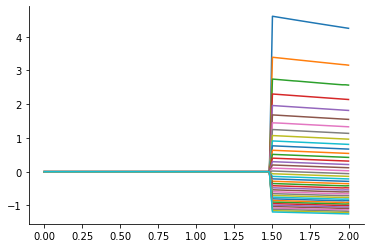

In [477]:
plt.plot(y_grid_cap,ϕ_ref.T)
plt.show()

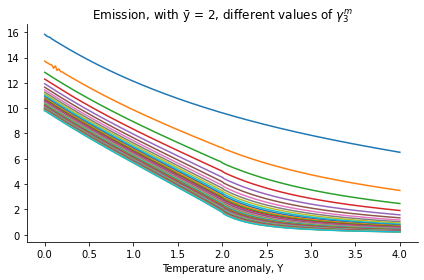

In [478]:
for i in range(len(dmg_weight)):
    plt.plot(y_grid,ems_list[-1, i, :])
plt.xlabel('Temperature anomaly, Y')
plt.title("Emission, with ȳ = 2, different values of $\gamma_3^m$")
plt.tight_layout()
# plt.savefig("ems.pdf", facecolor="w", edgecolor="w")
plt.show()

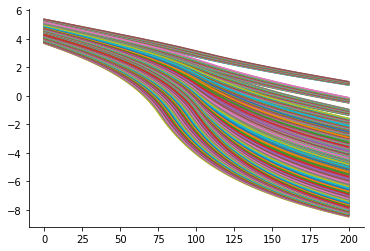

In [20]:
for i in range(len(res_list)):
    plt.plot(res_list[i]['φ'])

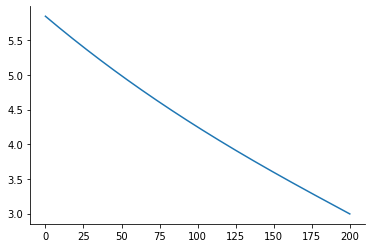

In [21]:
plt.plot(solution_low['φ'])

In [55]:
ϕ_ref.shape

(40, 101)

In [56]:
weighted = np.average(np.exp(-1/ξp*ϕ_ref), axis=0, weights=dmg_weight)

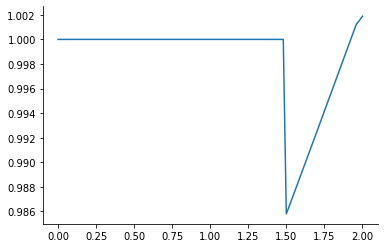

In [77]:
plt.plot(y_grid_cap, weighted)

In [24]:
from sympy.solvers import solve
from sympy import Symbol
x = Symbol('x')
ans = solve(x**3 + x**2 + x - 1, x)
r1 =np.log( float(ans[-1]))*2/(0.5/2)**2
# r0 = 1/(float(ans[-1])**4 - 1)/τ
r0 = - 0.4

In [25]:
r0, r1

(-0.4, -19.5000916299522)

In [26]:
numy_bar = len(pre_jump)-1
y_grid[:numy_bar+1]

array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
       0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
       0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
       0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
       0.88, 0.9 , 0.92, 0.94, 0.96, 0.98, 1.  , 1.02, 1.04, 1.06, 1.08,
       1.1 , 1.12, 1.14, 1.16, 1.18, 1.2 , 1.22, 1.24, 1.26, 1.28, 1.3 ,
       1.32, 1.34, 1.36, 1.38, 1.4 , 1.42, 1.44, 1.46, 1.48, 1.5 , 1.52,
       1.54, 1.56, 1.58, 1.6 , 1.62, 1.64, 1.66, 1.68, 1.7 , 1.72, 1.74,
       1.76, 1.78, 1.8 , 1.82, 1.84, 1.86, 1.88, 1.9 , 1.92, 1.94, 1.96,
       1.98, 2.  ])

In [27]:
ϕ_low = solution_low['φ']
ϕ_list_no_low = np.zeros((len(γ3_list[1:]), len(ϕ_low)))
for i in range(len(γ3_list[1:])):
    ϕ_list_no_low[i] = res_list[-(len(γ3_list[1:]) - i)]['φ']

In [28]:
ϕ_list_no_low.shape

(39, 201)

In [484]:
ϕ_list2 = np.concatenate(([ϕ_low], ϕ_list_no_low), axis=0)

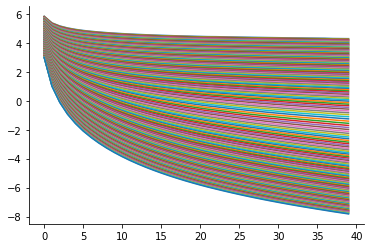

In [486]:
plt.plot(ϕ_list2)
plt.show()

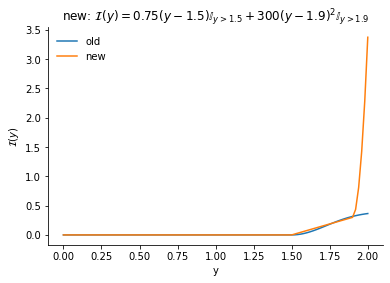

In [690]:
# plt.plot(y_grid_cap,3*intensity, label="x3")
# plt.plot(y_grid_cap,10*intensity, label="x10")
y_lower=1.5
intensity = r0*(np.exp(r1/2*(y_grid_cap- y_lower)**2)-1)*(y_grid_cap >= y_lower)
plt.plot(y_grid_cap, intensity, label="old")
y_lower=1.5
I = -1/2*r0*(np.exp((-r1)/4*(y_grid_cap- y_lower))-1)*(y_grid_cap >= y_lower)

# plt.plot(y_grid_cap, I, label="1.5")
y_lower=1.4
IO = -1/2*r0*(np.exp((-r1)/4*(y_grid_cap- y_lower))-1)*(y_grid_cap >= y_lower)
# plt.plot(y_grid_cap, IO, label="1.4")

func = 3/(y_bar - y_lower)**2*(y_grid_cap - y_lower)**2*(y_grid_cap >= y_lower)
# plt.plot(y_grid_cap, func, label="test 1.4")

func1 = 3/(y_bar - 1.5)**2*(y_grid_cap -1.5)**2*(y_grid_cap >= 1.5)
# plt.plot(y_grid_cap, func1, label="test 1.5")

func2 = 0.3/(1.9-1.5)*(y_grid_cap - 1.5)*(y_grid_cap>1.5) + 300*(y_grid_cap - 1.9)**2*(y_grid_cap>1.9)
plt.plot(y_grid_cap, func2, label="new")

plt.title(r"new: $\mathcal{I}(y) = 0.75(y - 1.5)\mathbb{I}_{y>1.5} + 300(y - 1.9)^2\mathbb{I}_{y > 1.9}$")
plt.xlabel('y')
plt.ylabel(r"$\mathcal{I}(y)$")
plt.legend(frameon=False)
# plt.savefig('intensity.png',dpi=500, facecolor="w", edgecolor="w")

In [668]:
0.3/(1.9-1.5)

0.7500000000000001

In [488]:
y_lower=1.5
r0*(np.exp(r1/2*(1.9- y_lower)**2)-1)*(1.9 >= y_lower)

0.31594618766969684

In [1062]:
numy_bar = len(pre_jump)-1
y_grid_cap = y_grid[:numy_bar+1]

y_lower = 1.5
# intensity = r0*(np.exp(r1/2*(y_grid_cap- y_lower)**2)-1)*(y_grid_cap >= y_lower)
intensity = 0.3/(1.9-1.5)*(y_grid_cap - 1.5)*(y_grid_cap>1.5) + 300*(y_grid_cap - 1.9)**2*(y_grid_cap>1.9)

dΛ = γ1 + γ2*y_grid_cap
ddΛ = γ2


ϕ = np.average(ϕ_list2, axis=0, weights=dmg_weight)[:numy_bar+1]
dy = hy
ems = η
ems_old = ems
episode = 0
lhs_error = 1
πᵈo = dmg_weight
πᶜo = np.ones((len(θ_list), len(y_grid_cap)))/len(θ_list)


tol= 1e-8
ϵ = 1
max_iter = 4000
while lhs_error > tol and episode < max_iter:
    ϕ_old = ϕ.copy()
    dϕdy = derivative_1d(ϕ, 1, dy, "up")
    dϕdyy = derivative_1d(ϕ, 2, dy, "up")
    # update control
    temp = dϕdy + (η-1)/δ*dΛ 
    weight = np.array([ - 1/ξa*temp*ems*θ for θ in θ_list])
    weight = weight - np.max(weight, axis=0)
    πᶜ = πᶜo*np.exp(weight)
    πᶜ[πᶜ <= 1e-15] = 1e-15
    πᶜ = πᶜ/np.sum(πᶜ, axis=0)
    # update control
    a = (dϕdyy  - 1/ξw*temp**2 + (η-1)/δ*ddΛ)*σy**2
    b = (θ_list@πᶜ)*temp
    c = η
    Δ = b**2 - 4*a*c
    Δ[Δ < 0] = 0
    root1 = (-b - np.sqrt(Δ))/(2*a)
    root2 = (-b + np.sqrt(Δ))/(2*a)
    if root1.all() > 0:
        ems_new = root1
    else:
        ems_new = root2
    ems_new[ems_new < 1e-15] = 1e-15
    ems = ems_new*0.5 + ems_old*0.5
    
    g_list = np.exp(1/ξp*(ϕ - ϕ_ref)) 
    weighted = np.average(np.exp(-1/ξp*ϕ_ref), axis=0, weights=dmg_weight)
    # coefficients
    A = -δ*np.ones(y_grid_cap.shape)
    By = (θ_list@πᶜ)*ems
    Cyy = ems**2*σy**2/2
    D = η*np.log(ems) + θ_list@πᶜ*(η-1)/δ*dΛ*ems\
    + ξa*np.sum(πᶜ*(np.log(πᶜ) - np.log(πᶜo)), axis=0) \
    - 1/(2*ξw)*temp**2*ems**2*σy**2\
    + 1/2*(η-1)/δ*ddΛ*ems**2*σy**2\
    - intensity*ξp*(weighted  - np.exp(-1/ξp*ϕ))/np.exp(-1/ξp*ϕ)
#     + ξp*intensity * (dmg_weight@(1 - g_list + g_list * np.log(g_list)))\
#     + intensity * (dmg_weight@(g_list*(ϕ_ref - ϕ)))
    # solver
    ϕ_new = solve_ode(A, By, Cyy, D, y_grid_cap, ϕ, ϵ, (False, weighted[numy_bar]))
    rhs = -δ*ϕ_new + By*dϕdy + Cyy*dϕdyy + D
    rhs_error = np.max(abs(rhs))
    lhs_error = np.max(abs((ϕ_new - ϕ_old)/ϵ))
    ϕ = ϕ_new
    episode += 1
    ems_old = ems

    print("episode: {},\t ode error: {},\t ft error: {}".format(episode, rhs_error, lhs_error))

solution = dict(ϕ=ϕ, ems=ems, g_list=g_list)

episode: 1,	 ode error: 0.251969603934845,	 ft error: 0.2517299570087881
episode: 2,	 ode error: 0.18153369531879704,	 ft error: 0.180648487175327
episode: 3,	 ode error: 0.14161601193517184,	 ft error: 0.14028154077315635
episode: 4,	 ode error: 0.11676950383301327,	 ft error: 0.1149258807757988
episode: 5,	 ode error: 0.09975128189982903,	 ft error: 0.09760829480327182
episode: 6,	 ode error: 0.08751068284587836,	 ft error: 0.08535197747860723
episode: 7,	 ode error: 0.07817386771962398,	 ft error: 0.07623692541774185
episode: 8,	 ode error: 0.07119971508706627,	 ft error: 0.06887884978187031
episode: 9,	 ode error: 0.06564753736402523,	 ft error: 0.06341666736268603
episode: 10,	 ode error: 0.06096698223222769,	 ft error: 0.058713216427076054
episode: 11,	 ode error: 0.05718732149945999,	 ft error: 0.05510429562210428
episode: 12,	 ode error: 0.054100459530116426,	 ft error: 0.05153469606613337
episode: 13,	 ode error: 0.05095703221121395,	 ft error: 0.04922535720391563
episode: 14,

episode: 162,	 ode error: 0.004293594701721193,	 ft error: 0.00432864636333985
episode: 163,	 ode error: 0.004260986616075407,	 ft error: 0.004277864174940582
episode: 164,	 ode error: 0.004224069851573198,	 ft error: 0.004227671109476638
episode: 165,	 ode error: 0.004182737355945071,	 ft error: 0.004177924966143998
episode: 166,	 ode error: 0.004136896019722752,	 ft error: 0.0041269542830209005
episode: 167,	 ode error: 0.004086469777767554,	 ft error: 0.004071298113488275
episode: 168,	 ode error: 0.004031402828483008,	 ft error: 0.004010924265905658
episode: 169,	 ode error: 0.003971662902433712,	 ft error: 0.0039458275689820965
episode: 170,	 ode error: 0.003907244498360843,	 ft error: 0.0038760329976303964
episode: 171,	 ode error: 0.0038381719919528823,	 ft error: 0.003801598563772046
episode: 172,	 ode error: 0.003764502512100601,	 ft error: 0.003722617858324284
episode: 173,	 ode error: 0.003686328471487116,	 ft error: 0.0036392221268801705
episode: 174,	 ode error: 0.00360377

episode: 317,	 ode error: 0.00199423490923192,	 ft error: 1.9610286243476605e-05
episode: 318,	 ode error: 0.0019941748946120455,	 ft error: 1.83428300068178e-05
episode: 319,	 ode error: 0.0019941407404776186,	 ft error: 1.0919314102131317e-05
episode: 320,	 ode error: 0.001994154152104549,	 ft error: 1.5671887166501808e-05
episode: 321,	 ode error: 0.0019941364260525583,	 ft error: 2.4315066964375465e-05
episode: 322,	 ode error: 0.0019938651603057522,	 ft error: 2.0887496146204665e-05
episode: 323,	 ode error: 0.001993907665658011,	 ft error: 1.9603344285024082e-05
episode: 324,	 ode error: 0.0019937210778574813,	 ft error: 1.9103856494173677e-05
episode: 325,	 ode error: 0.001993776684795962,	 ft error: 1.9028350523420112e-05
episode: 326,	 ode error: 0.0019939143095322673,	 ft error: 2.063353939196766e-05
episode: 327,	 ode error: 0.0019939518250465284,	 ft error: 1.6097451640106897e-05
episode: 328,	 ode error: 0.001994046298813626,	 ft error: 8.464961919252278e-06
episode: 329,	

episode: 460,	 ode error: 0.001993605132871057,	 ft error: 2.0601363881572743e-05
episode: 461,	 ode error: 0.001993680454235227,	 ft error: 1.6085203265348014e-05
episode: 462,	 ode error: 0.001993812191840187,	 ft error: 8.458001015676508e-06
episode: 463,	 ode error: 0.001993892875151202,	 ft error: 1.4765530205712585e-05
episode: 464,	 ode error: 0.001993846391599125,	 ft error: 2.3185910637907314e-05
episode: 465,	 ode error: 0.0019938875786183925,	 ft error: 2.1773990055207193e-05
episode: 466,	 ode error: 0.0019937603576543304,	 ft error: 5.675238197111465e-06
episode: 467,	 ode error: 0.001993632534362126,	 ft error: 1.3754005403376901e-05
episode: 468,	 ode error: 0.001993556099451333,	 ft error: 1.6335758079771834e-05
episode: 469,	 ode error: 0.001993387173878234,	 ft error: 1.4019816888893866e-05
episode: 470,	 ode error: 0.0019933070465786955,	 ft error: 2.4218727602526302e-05
episode: 471,	 ode error: 0.001993330521815141,	 ft error: 3.33818191909363e-05
episode: 472,	 od

episode: 583,	 ode error: 0.001993633053478012,	 ft error: 2.1125956452067163e-05
episode: 584,	 ode error: 0.001993781810966558,	 ft error: 2.0571592743240386e-05
episode: 585,	 ode error: 0.0019935826162543295,	 ft error: 1.9349165171322902e-05
episode: 586,	 ode error: 0.001993641141422111,	 ft error: 2.2916554088731056e-05
episode: 587,	 ode error: 0.001993783624350952,	 ft error: 1.694921520761783e-05
episode: 588,	 ode error: 0.00199388110577536,	 ft error: 2.5954724081372893e-05
episode: 589,	 ode error: 0.0019937564306833216,	 ft error: 2.953106920636217e-05
episode: 590,	 ode error: 0.001993794311766335,	 ft error: 1.144837717559355e-05
episode: 591,	 ode error: 0.0019938000443858912,	 ft error: 1.8421630780612874e-05
episode: 592,	 ode error: 0.0019939022834248345,	 ft error: 7.690129204346308e-06
episode: 593,	 ode error: 0.001993997002643924,	 ft error: 1.6754989801526232e-05
episode: 594,	 ode error: 0.0019939812896581297,	 ft error: 1.3109818120776717e-05
episode: 595,	 o

episode: 718,	 ode error: 0.001993699772955007,	 ft error: 2.3436913988400532e-05
episode: 719,	 ode error: 0.0019938064595588292,	 ft error: 1.9593755937630242e-05
episode: 720,	 ode error: 0.001993690241628751,	 ft error: 1.912378855317698e-05
episode: 721,	 ode error: 0.001993794217129457,	 ft error: 2.6922489225505997e-05
episode: 722,	 ode error: 0.001993995619814431,	 ft error: 2.0110252970662046e-05
episode: 723,	 ode error: 0.0019940828349071064,	 ft error: 9.967713261088695e-06
episode: 724,	 ode error: 0.0019941080565198353,	 ft error: 1.4701533886635199e-05
episode: 725,	 ode error: 0.001994119923402149,	 ft error: 8.868206953976943e-06
episode: 726,	 ode error: 0.0019940980204970517,	 ft error: 1.4799765726020153e-05
episode: 727,	 ode error: 0.0019940255595627676,	 ft error: 2.4676962975450634e-05
episode: 728,	 ode error: 0.0019937088018426342,	 ft error: 2.1589377305314406e-05
episode: 729,	 ode error: 0.001993733767272087,	 ft error: 1.967520114387611e-05
episode: 730,	

episode: 852,	 ode error: 0.0019932891749313043,	 ft error: 1.3169448679767326e-05
episode: 853,	 ode error: 0.0019933250165363355,	 ft error: 2.323011953253573e-05
episode: 854,	 ode error: 0.001993054826307971,	 ft error: 1.850531484554052e-05
episode: 855,	 ode error: 0.0019930995716166446,	 ft error: 1.8563157892143023e-05
episode: 856,	 ode error: 0.001993196258290194,	 ft error: 1.580403254808349e-05
episode: 857,	 ode error: 0.0019932311379998076,	 ft error: 1.3998968310280357e-05
episode: 858,	 ode error: 0.0019933546347143116,	 ft error: 1.8302972092015812e-05
episode: 859,	 ode error: 0.00199333486239495,	 ft error: 1.4595871853956277e-05
episode: 860,	 ode error: 0.00199337036029271,	 ft error: 1.0976037771726066e-05
episode: 861,	 ode error: 0.0019934053516918147,	 ft error: 1.6325088613045047e-05
episode: 862,	 ode error: 0.001993356926033505,	 ft error: 1.601774584411575e-05
episode: 863,	 ode error: 0.0019932542913008305,	 ft error: 1.9818953528927263e-05
episode: 864,	 

episode: 971,	 ode error: 0.0019941018590352057,	 ft error: 5.847779356832339e-06
episode: 972,	 ode error: 0.0019940365617996114,	 ft error: 1.7331779883028586e-05
episode: 973,	 ode error: 0.0019938812148650037,	 ft error: 1.3915461860941614e-05
episode: 974,	 ode error: 0.001993793046026114,	 ft error: 1.8926111302025594e-05
episode: 975,	 ode error: 0.00199376167484408,	 ft error: 2.5030280397353444e-05
episode: 976,	 ode error: 0.001993598182760979,	 ft error: 4.572483478099132e-06
episode: 977,	 ode error: 0.0019934650970985512,	 ft error: 1.5207794814758868e-05
episode: 978,	 ode error: 0.0019933929316682253,	 ft error: 1.3765055236009127e-05
episode: 979,	 ode error: 0.0019932394631542692,	 ft error: 2.0273386173247365e-05
episode: 980,	 ode error: 0.0019932262559376676,	 ft error: 1.854610669446699e-05
episode: 981,	 ode error: 0.001993111978620992,	 ft error: 7.984596808729982e-06
episode: 982,	 ode error: 0.0019930124171086624,	 ft error: 1.3819667450537532e-05
episode: 983,

episode: 1087,	 ode error: 0.0019937757767941357,	 ft error: 1.8788580026601887e-05
episode: 1088,	 ode error: 0.0019939073981776745,	 ft error: 3.0146679871306814e-05
episode: 1089,	 ode error: 0.00199410385527821,	 ft error: 2.392760074676481e-05
episode: 1090,	 ode error: 0.001994139234199461,	 ft error: 4.839449137511442e-06
episode: 1091,	 ode error: 0.001994145395180936,	 ft error: 1.291187575672148e-05
episode: 1092,	 ode error: 0.001994144813151591,	 ft error: 2.141767398233796e-05
episode: 1093,	 ode error: 0.0019939827428451067,	 ft error: 1.772892610105159e-05
episode: 1094,	 ode error: 0.0019939084716486533,	 ft error: 5.799512222876002e-06
episode: 1095,	 ode error: 0.0019938266157488484,	 ft error: 1.679944730698102e-05
episode: 1096,	 ode error: 0.001993672091098332,	 ft error: 1.3665225318731933e-05
episode: 1097,	 ode error: 0.001993653068060538,	 ft error: 2.3993689056478473e-05
episode: 1098,	 ode error: 0.001993343330871686,	 ft error: 2.0680145255219662e-05
episode

episode: 1205,	 ode error: 0.001993572409139839,	 ft error: 1.9008258322184002e-05
episode: 1206,	 ode error: 0.0019937532589859065,	 ft error: 2.0896899774192068e-05
episode: 1207,	 ode error: 0.0019938246788083237,	 ft error: 1.630373212146985e-05
episode: 1208,	 ode error: 0.0019939479400205573,	 ft error: 8.07250314804886e-06
episode: 1209,	 ode error: 0.0019940146026718453,	 ft error: 1.4758565616918018e-05
episode: 1210,	 ode error: 0.001993956660771269,	 ft error: 1.8068214126781834e-05
episode: 1211,	 ode error: 0.0019939630884924647,	 ft error: 1.6396268444296425e-05
episode: 1212,	 ode error: 0.0019938434877205605,	 ft error: 1.542173204768793e-05
episode: 1213,	 ode error: 0.001993672197588177,	 ft error: 1.930358461427195e-05
episode: 1214,	 ode error: 0.0019935843476725015,	 ft error: 5.063643845892862e-06
episode: 1215,	 ode error: 0.0019935111335018865,	 ft error: 2.3779646386390407e-05
episode: 1216,	 ode error: 0.001993350530512396,	 ft error: 1.979189645118229e-05
epi

episode: 1323,	 ode error: 0.0019939454148608093,	 ft error: 1.9862771419631997e-05
episode: 1324,	 ode error: 0.001994111267305698,	 ft error: 5.937396087202229e-06
episode: 1325,	 ode error: 0.0019942316322462857,	 ft error: 2.236060913771154e-05
episode: 1326,	 ode error: 0.001994018172280305,	 ft error: 1.78587935852903e-05
episode: 1327,	 ode error: 0.0019940492545323374,	 ft error: 1.7313495102422305e-05
episode: 1328,	 ode error: 0.0019941278688904787,	 ft error: 2.205253594661505e-05
episode: 1329,	 ode error: 0.001993950360254928,	 ft error: 1.78157820408531e-05
episode: 1330,	 ode error: 0.0019940021428832937,	 ft error: 1.964115691463486e-05
episode: 1331,	 ode error: 0.0019940840794856786,	 ft error: 1.5835027659810708e-05
episode: 1332,	 ode error: 0.00199407285805929,	 ft error: 1.5544678193729622e-05
episode: 1333,	 ode error: 0.001994128274998494,	 ft error: 1.4719240846089443e-05
episode: 1334,	 ode error: 0.0019940380093541876,	 ft error: 1.6776870939927413e-05
episod

episode: 1442,	 ode error: 0.0019941421762528083,	 ft error: 5.631978818643191e-06
episode: 1443,	 ode error: 0.001994023805053903,	 ft error: 1.7507840455788237e-05
episode: 1444,	 ode error: 0.0019938350752121033,	 ft error: 1.4147241772538566e-05
episode: 1445,	 ode error: 0.001993731526504533,	 ft error: 1.5621797256254455e-05
episode: 1446,	 ode error: 0.0019936794510598127,	 ft error: 2.1042008957361524e-05
episode: 1447,	 ode error: 0.001993530128886596,	 ft error: 5.996070268299292e-06
episode: 1448,	 ode error: 0.0019933995594453024,	 ft error: 1.357111568023317e-05
episode: 1449,	 ode error: 0.0019933358956257356,	 ft error: 1.899262220428355e-05
episode: 1450,	 ode error: 0.001993177763520145,	 ft error: 1.6032230421486604e-05
episode: 1451,	 ode error: 0.0019931365766716475,	 ft error: 7.606269333243487e-06
episode: 1452,	 ode error: 0.0019931202497456314,	 ft error: 1.4183126284234016e-05
episode: 1453,	 ode error: 0.0019930413787260896,	 ft error: 2.3126168115922274e-05
e

episode: 1563,	 ode error: 0.0019943236140842965,	 ft error: 1.5017001211176106e-05
episode: 1564,	 ode error: 0.001994277570304029,	 ft error: 8.392291550640696e-06
episode: 1565,	 ode error: 0.0019942071088939195,	 ft error: 1.4556079004579559e-05
episode: 1566,	 ode error: 0.001994098026395861,	 ft error: 2.4425825005169877e-05
episode: 1567,	 ode error: 0.0019937533759610514,	 ft error: 2.0660681839757e-05
episode: 1568,	 ode error: 0.0019936951803929265,	 ft error: 3.271550392427991e-05
episode: 1569,	 ode error: 0.0019937615935266724,	 ft error: 2.741218360860498e-05
episode: 1570,	 ode error: 0.001993692960284458,	 ft error: 3.6157810220649456e-06
episode: 1571,	 ode error: 0.001993662004348532,	 ft error: 1.4092414688859911e-05
episode: 1572,	 ode error: 0.0019936525904907,	 ft error: 1.4331043186238679e-05
episode: 1573,	 ode error: 0.001993535770808727,	 ft error: 1.4031117398255466e-05
episode: 1574,	 ode error: 0.001993507398973436,	 ft error: 1.4241298313732997e-05
episode

episode: 1683,	 ode error: 0.0019928625172310546,	 ft error: 1.9250223267180955e-05
episode: 1684,	 ode error: 0.0019930196864577504,	 ft error: 1.8981650328542266e-05
episode: 1685,	 ode error: 0.001993259025664249,	 ft error: 2.0592774931049718e-05
episode: 1686,	 ode error: 0.0019933937535522063,	 ft error: 1.6081875331641626e-05
episode: 1687,	 ode error: 0.0019935778764557516,	 ft error: 8.459613475064742e-06
episode: 1688,	 ode error: 0.0019937035435770994,	 ft error: 1.4765073525158101e-05
episode: 1689,	 ode error: 0.0019936948124730687,	 ft error: 2.3232468789935456e-05
episode: 1690,	 ode error: 0.0019937673876896586,	 ft error: 2.1828287605496488e-05
episode: 1691,	 ode error: 0.001993665366688699,	 ft error: 5.651232197756428e-06
episode: 1692,	 ode error: 0.0019935580069247102,	 ft error: 1.3771931539952043e-05
episode: 1693,	 ode error: 0.001993497761878661,	 ft error: 1.6193713895301665e-05
episode: 1694,	 ode error: 0.0019933421997946933,	 ft error: 1.3924727141040316e-

episode: 1803,	 ode error: 0.0019939637308897737,	 ft error: 1.8118060279570525e-05
episode: 1804,	 ode error: 0.001993966322925273,	 ft error: 1.6441849801207553e-05
episode: 1805,	 ode error: 0.001993843887962473,	 ft error: 1.5072304669544456e-05
episode: 1806,	 ode error: 0.00199367241877035,	 ft error: 1.9004290588264805e-05
episode: 1807,	 ode error: 0.001993583239796669,	 ft error: 5.149418771388525e-06
episode: 1808,	 ode error: 0.001993508244427799,	 ft error: 2.160972286111007e-05
episode: 1809,	 ode error: 0.001993355391210379,	 ft error: 1.779325800724263e-05
episode: 1810,	 ode error: 0.0019933202378090466,	 ft error: 5.786032073740177e-06
episode: 1811,	 ode error: 0.0019932936524714,	 ft error: 1.672760242485416e-05
episode: 1812,	 ode error: 0.0019932027339901806,	 ft error: 1.3657435285474584e-05
episode: 1813,	 ode error: 0.001993249571954677,	 ft error: 2.4030522378482022e-05
episode: 1814,	 ode error: 0.0019930032688022965,	 ft error: 2.0734419547197014e-05
episode:

episode: 1920,	 ode error: 0.0019934019880725184,	 ft error: 2.4413964136799082e-05
episode: 1921,	 ode error: 0.001993100071723805,	 ft error: 2.1425781453726644e-05
episode: 1922,	 ode error: 0.001993173079726355,	 ft error: 1.9827449179221635e-05
episode: 1923,	 ode error: 0.00199304238130258,	 ft error: 1.9048335620247547e-05
episode: 1924,	 ode error: 0.0019931674911485738,	 ft error: 1.8916160512277846e-05
episode: 1925,	 ode error: 0.0019933791487689242,	 ft error: 2.131527551424428e-05
episode: 1926,	 ode error: 0.001993487684142571,	 ft error: 1.663751325156615e-05
episode: 1927,	 ode error: 0.00199365442100077,	 ft error: 7.5367593869724026e-06
episode: 1928,	 ode error: 0.0019937627103074583,	 ft error: 1.4964035344094961e-05
episode: 1929,	 ode error: 0.001993747363438207,	 ft error: 1.4474558075960875e-05
episode: 1930,	 ode error: 0.001993778770300894,	 ft error: 1.4200477889525498e-05
episode: 1931,	 ode error: 0.0019936768255258974,	 ft error: 1.7191190855442295e-05
epi

episode: 2040,	 ode error: 0.001994282150587893,	 ft error: 1.4967995022319158e-05
episode: 2041,	 ode error: 0.00199418950778895,	 ft error: 1.4639710561342723e-05
episode: 2042,	 ode error: 0.001994149700171203,	 ft error: 1.4201858102441678e-05
episode: 2043,	 ode error: 0.001993982549113843,	 ft error: 1.8832171790272856e-05
episode: 2044,	 ode error: 0.0019939175511995214,	 ft error: 1.7130739493359526e-05
episode: 2045,	 ode error: 0.0019937447228329033,	 ft error: 1.1051230833308834e-05
episode: 2046,	 ode error: 0.001993561939309701,	 ft error: 1.573273921431917e-05
episode: 2047,	 ode error: 0.001993453279564534,	 ft error: 8.053403911356671e-06
episode: 2048,	 ode error: 0.0019933781020802788,	 ft error: 1.4293870156917299e-05
episode: 2049,	 ode error: 0.001993304909254999,	 ft error: 2.469062871277017e-05
episode: 2050,	 ode error: 0.00199302224651721,	 ft error: 2.0816559601732898e-05
episode: 2051,	 ode error: 0.0019930402401367765,	 ft error: 3.3475546892619557e-05
episo

episode: 2160,	 ode error: 0.0019932086426750657,	 ft error: 1.882945842515693e-05
episode: 2161,	 ode error: 0.001993403906014577,	 ft error: 2.2544949386416047e-05
episode: 2162,	 ode error: 0.001993496347826435,	 ft error: 1.7626302477063982e-05
episode: 2163,	 ode error: 0.0019936584054630613,	 ft error: 6.62271572754447e-06
episode: 2164,	 ode error: 0.001993762211068454,	 ft error: 1.6982579910118645e-05
episode: 2165,	 ode error: 0.0019937408933597897,	 ft error: 1.3205962705487018e-05
episode: 2166,	 ode error: 0.001993807412126479,	 ft error: 2.3892541393094602e-05
episode: 2167,	 ode error: 0.001993546698127204,	 ft error: 2.1042208649013627e-05
episode: 2168,	 ode error: 0.001993625999349248,	 ft error: 1.963771349791643e-05
episode: 2169,	 ode error: 0.0019934778632426688,	 ft error: 1.899138375890952e-05
episode: 2170,	 ode error: 0.001993570283665227,	 ft error: 1.8980116062800034e-05
episode: 2171,	 ode error: 0.0019937401325906996,	 ft error: 2.090728301398781e-05
episo

episode: 2277,	 ode error: 0.0019932018415197775,	 ft error: 1.413924314863646e-05
episode: 2278,	 ode error: 0.001993119252377752,	 ft error: 2.307033094917088e-05
episode: 2279,	 ode error: 0.00199316918631863,	 ft error: 2.1751000207986815e-05
episode: 2280,	 ode error: 0.001993079505619475,	 ft error: 5.682162520087575e-06
episode: 2281,	 ode error: 0.0019930091312601386,	 ft error: 1.3879273973588235e-05
episode: 2282,	 ode error: 0.0019930002991459597,	 ft error: 1.5872100414732193e-05
episode: 2283,	 ode error: 0.001992904591191051,	 ft error: 1.3771654092303853e-05
episode: 2284,	 ode error: 0.001992958249219738,	 ft error: 2.4332594621589987e-05
episode: 2285,	 ode error: 0.0019927283445582596,	 ft error: 2.118840898174268e-05
episode: 2286,	 ode error: 0.001992867119848186,	 ft error: 1.985006250335153e-05
episode: 2287,	 ode error: 0.0019927943056003185,	 ft error: 1.9116554133280506e-05
episode: 2288,	 ode error: 0.001992969359635912,	 ft error: 1.898726787899485e-05
episod

episode: 2395,	 ode error: 0.001993544762179094,	 ft error: 1.9925304430845614e-05
episode: 2396,	 ode error: 0.001993857180118075,	 ft error: 2.066780189688422e-05
episode: 2397,	 ode error: 0.0019939143873013675,	 ft error: 1.6949968293655804e-05
episode: 2398,	 ode error: 0.0019941313934334244,	 ft error: 1.8318625110508302e-05
episode: 2399,	 ode error: 0.0019943643458851107,	 ft error: 2.1682166823994153e-05
episode: 2400,	 ode error: 0.0019942919471085986,	 ft error: 1.788501271993148e-05
episode: 2401,	 ode error: 0.0019943949145618395,	 ft error: 2.631430544330904e-05
episode: 2402,	 ode error: 0.001994522808727306,	 ft error: 2.003249182308542e-05
episode: 2403,	 ode error: 0.001994511312816069,	 ft error: 8.855891723308362e-06
episode: 2404,	 ode error: 0.0019944452798373973,	 ft error: 1.4280530661797686e-05
episode: 2405,	 ode error: 0.0019943719091947733,	 ft error: 1.1088076338539032e-05
episode: 2406,	 ode error: 0.001994288099116271,	 ft error: 1.6432282502837348e-05
ep

episode: 2529,	 ode error: 0.001993322462836695,	 ft error: 2.3231112928540076e-05
episode: 2530,	 ode error: 0.001993063645529248,	 ft error: 1.8292698467647917e-05
episode: 2531,	 ode error: 0.001993114501162869,	 ft error: 1.7506933136346436e-05
episode: 2532,	 ode error: 0.0019932165184363172,	 ft error: 2.1246419808135242e-05
episode: 2533,	 ode error: 0.001993233877779551,	 ft error: 1.6724149787705755e-05
episode: 2534,	 ode error: 0.001993348705908008,	 ft error: 6.746153254050258e-06
episode: 2535,	 ode error: 0.0019934323401298963,	 ft error: 1.5565143037216123e-05
episode: 2536,	 ode error: 0.001993414289379547,	 ft error: 1.2981218600327527e-05
episode: 2537,	 ode error: 0.001993461153740994,	 ft error: 2.229287519123213e-05
episode: 2538,	 ode error: 0.0019933558474686114,	 ft error: 1.8750946139678426e-05
episode: 2539,	 ode error: 0.0019933540286324984,	 ft error: 5.385057029488882e-06
episode: 2540,	 ode error: 0.0019933475125789545,	 ft error: 2.039432039183109e-05
epi

episode: 2654,	 ode error: 0.0019936303394714854,	 ft error: 1.0218840499204296e-05
episode: 2655,	 ode error: 0.0019936524448688174,	 ft error: 1.5679604570745242e-05
episode: 2656,	 ode error: 0.001993624932993699,	 ft error: 2.3197807713509766e-05
episode: 2657,	 ode error: 0.0019933525915165166,	 ft error: 2.020911996047925e-05
episode: 2658,	 ode error: 0.001993347318894636,	 ft error: 1.8667591460297395e-05
episode: 2659,	 ode error: 0.0019933910781709287,	 ft error: 9.651583768394145e-06
episode: 2660,	 ode error: 0.0019934864904072383,	 ft error: 1.5238983825521801e-05
episode: 2661,	 ode error: 0.0019935023979205206,	 ft error: 1.9495575312750146e-05
episode: 2662,	 ode error: 0.001993591426267427,	 ft error: 1.758932983883521e-05
episode: 2663,	 ode error: 0.0019935369363722616,	 ft error: 1.0424655411150896e-05
episode: 2664,	 ode error: 0.0019934437288866014,	 ft error: 1.526595879169923e-05
episode: 2665,	 ode error: 0.0019933969422251605,	 ft error: 9.077202063251244e-06


episode: 2777,	 ode error: 0.0019939475408508357,	 ft error: 6.118305986124728e-06
episode: 2778,	 ode error: 0.001994039548679244,	 ft error: 2.3490963028560685e-05
episode: 2779,	 ode error: 0.0019939724483067495,	 ft error: 1.8556263255836702e-05
episode: 2780,	 ode error: 0.001993971102300724,	 ft error: 5.491016208253319e-06
episode: 2781,	 ode error: 0.0019939371274488513,	 ft error: 2.175441533186495e-05
episode: 2782,	 ode error: 0.0019937912064819305,	 ft error: 1.760979688752995e-05
episode: 2783,	 ode error: 0.001993739695020147,	 ft error: 5.87487157327482e-06
episode: 2784,	 ode error: 0.0019936817508715357,	 ft error: 1.6581354240374768e-05
episode: 2785,	 ode error: 0.0019935513902740523,	 ft error: 1.352354834183167e-05
episode: 2786,	 ode error: 0.0019935542728263048,	 ft error: 2.4082529649888107e-05
episode: 2787,	 ode error: 0.0019932635768790535,	 ft error: 2.0996840683851214e-05
episode: 2788,	 ode error: 0.001993338763897956,	 ft error: 1.977140934436572e-05
epis

episode: 2916,	 ode error: 0.00199319258962365,	 ft error: 1.4249123180293255e-05
episode: 2917,	 ode error: 0.001993099118854969,	 ft error: 2.8115851854915164e-05
episode: 2918,	 ode error: 0.001993168275923385,	 ft error: 2.841279365883853e-05
episode: 2919,	 ode error: 0.0019930547420310626,	 ft error: 3.871806291966262e-06
episode: 2920,	 ode error: 0.0019929900033331116,	 ft error: 1.6496753162759115e-05
episode: 2921,	 ode error: 0.0019929868238075903,	 ft error: 1.4231535122477545e-05
episode: 2922,	 ode error: 0.0019929522736257185,	 ft error: 2.53652558404871e-05
episode: 2923,	 ode error: 0.0019927133692686574,	 ft error: 2.2876116485853748e-05
episode: 2924,	 ode error: 0.0019928325409701575,	 ft error: 1.8191187187793778e-05
episode: 2925,	 ode error: 0.001992781757650136,	 ft error: 8.193237889586591e-06
episode: 2926,	 ode error: 0.001992835398553265,	 ft error: 2.036573889202531e-05
episode: 2927,	 ode error: 0.001993064490759266,	 ft error: 1.990511030225406e-05
episod

episode: 3050,	 ode error: 0.001993306571723478,	 ft error: 1.603589064463895e-05
episode: 3051,	 ode error: 0.0019932837744701913,	 ft error: 7.487770606245947e-06
episode: 3052,	 ode error: 0.0019932710111436637,	 ft error: 1.4201841095240475e-05
episode: 3053,	 ode error: 0.0019931887017163516,	 ft error: 2.0474629216338247e-05
episode: 3054,	 ode error: 0.0019932256329219765,	 ft error: 1.8829296256572814e-05
episode: 3055,	 ode error: 0.0019931422405362435,	 ft error: 7.734980064177943e-06
episode: 3056,	 ode error: 0.0019930620957420084,	 ft error: 1.3710979382963728e-05
episode: 3057,	 ode error: 0.001993086593356251,	 ft error: 2.459613729940968e-05
episode: 3058,	 ode error: 0.0019928312113157293,	 ft error: 2.2061740707846056e-05
episode: 3059,	 ode error: 0.0019929449853433694,	 ft error: 1.9505687775672742e-05
episode: 3060,	 ode error: 0.001992853955617095,	 ft error: 1.8848380260449993e-05
episode: 3061,	 ode error: 0.001993010788712283,	 ft error: 1.839827268193539e-05
e

episode: 3199,	 ode error: 0.0019931755784902243,	 ft error: 2.149452848690392e-05
episode: 3200,	 ode error: 0.001993169054846245,	 ft error: 2.16936502373255e-05
episode: 3201,	 ode error: 0.0019932466771664763,	 ft error: 7.274776207294442e-06
episode: 3202,	 ode error: 0.001993402221420297,	 ft error: 2.2796313133177648e-05
episode: 3203,	 ode error: 0.001993294321869756,	 ft error: 1.7827939306297447e-05
episode: 3204,	 ode error: 0.0019934246617359305,	 ft error: 1.967972473349011e-05
episode: 3205,	 ode error: 0.0019935730552461013,	 ft error: 1.5592434710026692e-05
episode: 3206,	 ode error: 0.001993625592659653,	 ft error: 1.6989718213233918e-05
episode: 3207,	 ode error: 0.0019937489002256788,	 ft error: 1.5137380567686876e-05
episode: 3208,	 ode error: 0.0019937711608496167,	 ft error: 2.464551532482817e-05
episode: 3209,	 ode error: 0.0019935305751345514,	 ft error: 2.1819908882558803e-05
episode: 3210,	 ode error: 0.0019936093535676824,	 ft error: 1.9523260442882995e-05
ep

episode: 3337,	 ode error: 0.001993156067746197,	 ft error: 2.3086845660102995e-05
episode: 3338,	 ode error: 0.001993182125608277,	 ft error: 2.1744755983599262e-05
episode: 3339,	 ode error: 0.0019930760985467436,	 ft error: 5.695100394415009e-06
episode: 3340,	 ode error: 0.0019929958111383136,	 ft error: 1.3911780850278666e-05
episode: 3341,	 ode error: 0.0019929811499823057,	 ft error: 1.578887985628774e-05
episode: 3342,	 ode error: 0.0019928828846106084,	 ft error: 1.3738075390845594e-05
episode: 3343,	 ode error: 0.0019929358337221516,	 ft error: 2.4390799257062445e-05
episode: 3344,	 ode error: 0.0019927066872611233,	 ft error: 2.137350290667972e-05
episode: 3345,	 ode error: 0.0019928462902452163,	 ft error: 1.9811323205137787e-05
episode: 3346,	 ode error: 0.0019927754615510877,	 ft error: 1.9040510812917688e-05
episode: 3347,	 ode error: 0.0019929528907831617,	 ft error: 1.892220152402424e-05
episode: 3348,	 ode error: 0.0019932089353409607,	 ft error: 2.1293195098193163e-0

episode: 3489,	 ode error: 0.001994459420375686,	 ft error: 1.308049214376883e-05
episode: 3490,	 ode error: 0.001994341381098382,	 ft error: 1.946836248079009e-05
episode: 3491,	 ode error: 0.0019940975496852073,	 ft error: 1.61944639915923e-05
episode: 3492,	 ode error: 0.0019939561990764583,	 ft error: 7.190690645253461e-06
episode: 3493,	 ode error: 0.0019938323339079925,	 ft error: 1.423019576327067e-05
episode: 3494,	 ode error: 0.00199365355651792,	 ft error: 1.7147540401107886e-05
episode: 3495,	 ode error: 0.0019935922388550145,	 ft error: 1.5609662740417862e-05
episode: 3496,	 ode error: 0.001993485179752782,	 ft error: 2.3684076594948644e-05
episode: 3497,	 ode error: 0.001993163642597103,	 ft error: 1.9077997885141862e-05
episode: 3498,	 ode error: 0.0019931561289492916,	 ft error: 1.6999011781093643e-05
episode: 3499,	 ode error: 0.0019932484764658524,	 ft error: 2.3398613314629113e-05
episode: 3500,	 ode error: 0.0019931306841477654,	 ft error: 2.0610967198519958e-05
epis

episode: 3648,	 ode error: 0.0019938349485728694,	 ft error: 1.4275049083078972e-05
episode: 3649,	 ode error: 0.0019937583292447478,	 ft error: 1.616880708096846e-05
episode: 3650,	 ode error: 0.0019937535099896,	 ft error: 1.4854898917643355e-05
episode: 3651,	 ode error: 0.001993678892694875,	 ft error: 2.9673471750535363e-05
episode: 3652,	 ode error: 0.0019934234134375457,	 ft error: 2.2844558140000526e-05
episode: 3653,	 ode error: 0.001993267279658817,	 ft error: 1.8385369609741353e-05
episode: 3654,	 ode error: 0.001993333119787409,	 ft error: 1.901055543185315e-05
episode: 3655,	 ode error: 0.001993327098835613,	 ft error: 1.7914307683247754e-05
episode: 3656,	 ode error: 0.0019935209096778005,	 ft error: 1.929457609015084e-05
episode: 3657,	 ode error: 0.0019938158176151972,	 ft error: 2.1643955600419984e-05
episode: 3658,	 ode error: 0.001993850033257631,	 ft error: 1.8342495708895123e-05
episode: 3659,	 ode error: 0.001994047508635119,	 ft error: 2.616850596731668e-05
episo

episode: 3784,	 ode error: 0.001994264862552147,	 ft error: 1.663410078683869e-05
episode: 3785,	 ode error: 0.001994323484486124,	 ft error: 7.605592469012157e-06
episode: 3786,	 ode error: 0.0019943284249995356,	 ft error: 1.4944919322162908e-05
episode: 3787,	 ode error: 0.001994218138020542,	 ft error: 1.4715714596602592e-05
episode: 3788,	 ode error: 0.0019941660220625657,	 ft error: 1.4202518026390498e-05
episode: 3789,	 ode error: 0.001993989774728113,	 ft error: 1.9852791410479576e-05
episode: 3790,	 ode error: 0.001993923265680469,	 ft error: 1.8151847005237753e-05
episode: 3791,	 ode error: 0.0019937428055253163,	 ft error: 8.69761552887982e-06
episode: 3792,	 ode error: 0.001993565832549511,	 ft error: 1.4158749906234558e-05
episode: 3793,	 ode error: 0.00199344445572985,	 ft error: 2.0748127380398884e-05
episode: 3794,	 ode error: 0.0019934167645252326,	 ft error: 2.7687208036863975e-05
episode: 3795,	 ode error: 0.0019932565231741833,	 ft error: 3.980352216659266e-06
episo

episode: 3937,	 ode error: 0.0019936832543615,	 ft error: 2.128317424754389e-05
episode: 3938,	 ode error: 0.001993742901252732,	 ft error: 1.661444491063424e-05
episode: 3939,	 ode error: 0.00199386609552343,	 ft error: 7.582866028282842e-06
episode: 3940,	 ode error: 0.0019939365612545203,	 ft error: 1.4936499973056128e-05
episode: 3941,	 ode error: 0.0019938886399469245,	 ft error: 1.4672839928620007e-05
episode: 3942,	 ode error: 0.0019938931601062096,	 ft error: 1.4195035475617068e-05
episode: 3943,	 ode error: 0.001993767138384086,	 ft error: 1.9358247554751573e-05
episode: 3944,	 ode error: 0.001993741546022009,	 ft error: 1.7650479342129488e-05
episode: 3945,	 ode error: 0.001993599075650259,	 ft error: 9.65323733401191e-06
episode: 3946,	 ode error: 0.0019934488095733026,	 ft error: 1.4741466441592355e-05
episode: 3947,	 ode error: 0.0019933586220125254,	 ft error: 1.2139025705765194e-05
episode: 3948,	 ode error: 0.0019933161832980315,	 ft error: 1.7460745138059286e-05
episod

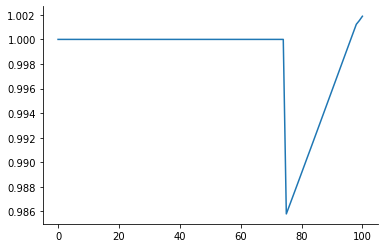

In [1063]:
weighted, ϕ_new, g_list[:,-1]
plt.plot(weighted)

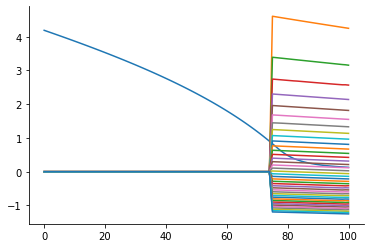

In [1064]:
plt.plot(ϕ)
plt.plot(ϕ_ref.T)
plt.show()

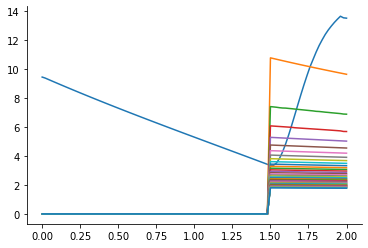

In [1065]:
plt.plot(y_grid_cap,ems)
plt.plot(y_grid_cap, ems_ref.T)
plt.show()

In [1066]:
g_list[:,-1]

array([0.43888099, 0.54603058, 0.61441248, 0.66913616, 0.71392336,
       0.75280963, 0.78655573, 0.81777007, 0.84639551, 0.8729097 ,
       0.89766304, 0.92092098, 0.94288993, 0.9637338 , 0.98358519,
       1.00255307, 1.02072819, 1.03818707, 1.05499495, 1.071208  ,
       1.08687493, 1.10203844, 1.11515361, 1.12936384, 1.14317609,
       1.15661684, 1.16970989, 1.18247665, 1.19493654, 1.20710715,
       1.21900456, 1.23064341, 1.24203717, 1.25319821, 1.26413792,
       1.27486683, 1.28539469, 1.29773953, 1.30789994, 1.31788328])

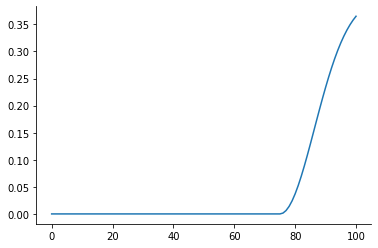

In [1057]:
plt.plot(intensity)

In [1007]:
r0, y_bar, y_lower

(-0.4, 2, 1.4)

In [1008]:
def no_jump_simulation():
    y = 1.1
    T = 120
    dt = 1
    T = int(T/dt)
    et = np.zeros(T)
    yt = np.zeros(T)
    probt = np.zeros(T)
    for t in range(T):
#         if y < 1.5:
#             print(t)
        if y <= y_bar:
            e_i = np.interp(y, y_grid_cap, ems)
#             prob_i = r0*(np.exp(r1/2*(y - y_lower)**2) - 1)*(y > y_lower)
            intensity = 0.75*(y - 1.5)*(y>1.5) + 300*(y - 1.9)**2*(y>1.9)
            prob_i = intensity*(intensity<1) + (intensity>=1)
            et[t] = e_i
            probt[t] = 1-prob_i
            yt[t] = y
            y = y + e_i*np.mean(θ_list)*dt
#         else:
#             break
    yt = yt[np.nonzero(yt)]
    et = et[np.nonzero(et)]
    probt = probt[np.nonzero(probt)]

    return et, yt, probt

In [1009]:
def no_jump_simulation_long(ems):
    y = 1.1
    T = 100
    dt = 1
    T = int(T/dt)
    et = np.zeros(T)
    yt = np.zeros(T)
    probt = np.zeros(T)
    for t in range(T):
#         if y >= 1.5:
#             print(t)
#         if y < y_bar:
        e_i = np.interp(y, y_grid, ems)
        intensity = 0.75*(y - 1.5)*(y>1.5) + 300*(y - 1.9)**2*(y>1.9)
        prob_i = intensity*(intensity<1) + (intensity>=1)
        et[t] = e_i
        probt[t] = 1-prob_i
        yt[t] = y
        y = y + e_i*np.mean(θ_list)*dt
    yt = yt[np.nonzero(yt)]
    et = et[np.nonzero(et)]
    probt = probt[np.nonzero(probt)]

    return et, yt, probt

In [1010]:
et, yt, probt = no_jump_simulation()

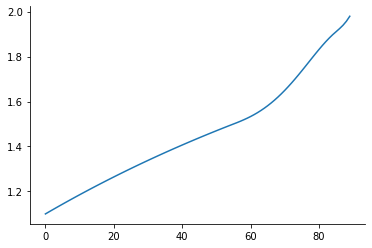

In [1011]:
plt.plot(yt)

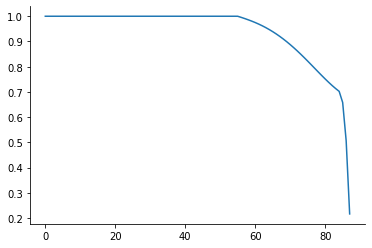

In [1012]:
# year = np.arange(0, T-τ, τ)
plt.plot(probt)
# plt.ylim(0)

In [1013]:
len(ems_list), jump_interval[-1]

(26, 2.0000000000000004)

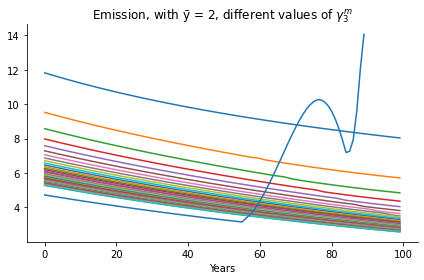

In [1014]:
et_tests = []
for i in range(len(dmg_weight)):
    et_test, _, _ = no_jump_simulation_long(ems_list[-1, i])
    plt.plot(et_test)
    et_tests.append(et_test)
    
plt.plot(et)    
plt.xlabel('Years')
plt.title("Emission, with ȳ = 2, different values of $\gamma_3^m$")
plt.tight_layout()
# plt.xlim(0,3)
# plt.savefig("ems.pdf", facecolor="w", edgecolor="w")
plt.show()

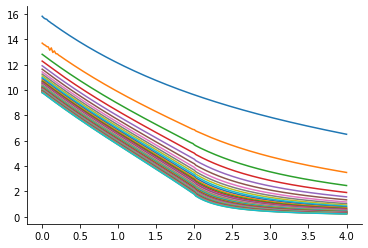

In [989]:
plt.plot(y_grid,ems_list[-1].T)
plt.show()

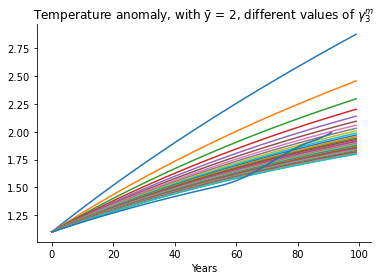

In [990]:
yt_refs = []
for i in range(len(dmg_weight)):
    _, yt_ref, _ = no_jump_simulation_long(ems_list[-1, i])
    plt.plot(yt_ref, label="$\gamma2$")
    yt_refs.append(yt_ref)

# plt.legend()    
plt.plot(yt)
plt.xlabel('Years')
plt.title("Temperature anomaly, with ȳ = 2, different values of $\gamma_3^m$")

# plt.xlim(0,89)
fig.tight_layout()
# plt.savefig("Y.pdf", facecolor="w", edgecolor="w")
plt.show()

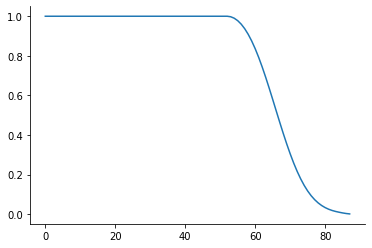

In [991]:
instensity = 1 - probt
integral = np.cumsum(instensity)
conti_prob = np.exp(- integral)
plt.plot(conti_prob)

In [992]:
prob_no_jump = np.cumprod(probt)
prob_no_jump, yt.shape

(array([1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
        1.00000000e+00, 9.97430661e-01, 9.90024535e-01, 9.775312

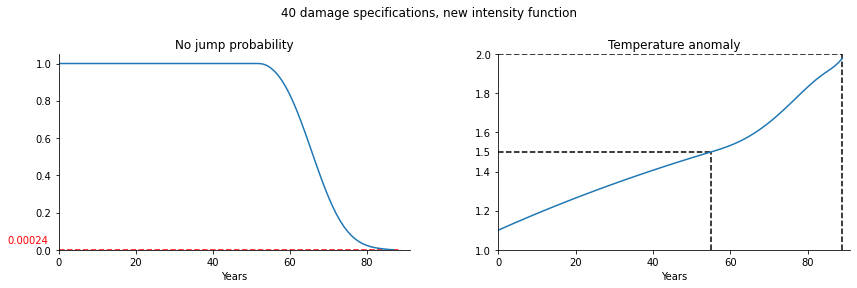

In [1019]:
import matplotlib.transforms as transforms
T_jump = np.abs(yt-1.5).argmin()
T_stop = len(yt)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
fig.suptitle('{} damage specifications, new intensity function'.format(len(dmg_weight)), y=0.99)
ax1.plot(prob_no_jump)
ax1.set_title("No jump probability")
ax1.set_xlabel('Years')
ax1.set_ylim(0)
ax1.set_xlim(0)
ax1.hlines(np.min(prob_no_jump), 0, T_stop-1, color="red", linestyle="dashed")
trans = transforms.blended_transform_factory(
    ax1.get_yticklabels()[0].get_transform(), ax1.transData)

ax1.text(-0.01,np.min(prob_no_jump)+0.05, "{:.05f}".format(np.min(prob_no_jump)), color="red", transform=trans, 
        ha="right", va="center")


ax2.plot(yt)
ax2.hlines(1.5, 0, T_jump, color="black", linestyle="dashed")
ax2.vlines(T_jump, 1, 1.5, color="black", linestyle="dashed" )
ax2.hlines(2, 0, T_stop-1, color="black", linestyle="dashed")
ax2.vlines(T_stop-1, 1, 2, color="black", linestyle="dashed" )
ax2.set_xlim(0, len(yt)+1) 
ax2.set_title('Temperature anomaly')
ax2.set_xlabel('Years')
ax2.set_ylim(1,2)
trans = transforms.blended_transform_factory(
    ax2.get_yticklabels()[0].get_transform(), ax2.transData)

ax1.text(0,1.5, 1.5, color="black", transform=trans, 
        ha="right", va="center")

fig.tight_layout()

# fig.savefig('prob_anomaly_new.png',dpi=500, facecolor="w", edgecolor="w")

In [1020]:
T_jump

55

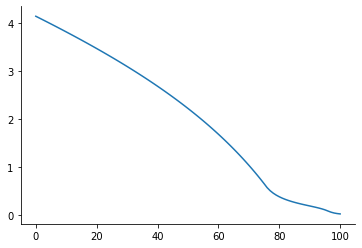

In [1021]:
ϕ_list.shape
plt.plot(ϕ)

In [1022]:
ϕ_list.shape, ems_list.shape

((26, 40, 201), (26, 40, 201))

In [997]:
def jump_simulation():
    θ_mean = np.mean(θ_list)
#     ems = solution['ems']
#     ϕ=solution["φ"]
    ems_list = res_dict['ems_list']
    ϕ_list = res_dict['φ_list']
    y0 = 1.1
    y_lower = 1.5
    T = 100
    dt = 1
    T = int(T/dt)
    et = np.zeros(T+1)
    yt = np.zeros(T+1)
    probt = np.zeros(T+1)
    prob_no = np.ones(T+1)
    y = y0
    for t in range(T):
        if y < y_lower:
            e_i = np.interp(y, y_grid_cap, ems)
#             prob_i = r0*(np.exp(r1/2*(y - y_lower)**2) - 1)*(y > y_lower)
            intensity = 0.75*(y - 1.5)*(y>1.5) + 300*(y - 1.9)**2*(y>1.9)
            prob_i = intensity*(intensity<1) + (intensity>=1)
            et[t] = e_i
            probt[t] = 1-prob_i
            prob_no[t] = np.cumprod(probt[:t+1])[-1]
            yt[t] = y
            y = y + et[t]*θ_mean*dt
        else:
            T_jump = t
            print(T_jump)
            break
    
    # get time span before 
    et = np.zeros(T+1)
    yt = np.zeros(T+1)
    probt = np.zeros(T+1)
    prob_no = np.ones(T+1)
    y = y0
    for t in range(T):
        if y <= y_bar:
            e_i = np.interp(y, y_grid_cap, ems)
#             prob_i = r0*(np.exp(r1/2*(y - y_lower)**2) - 1)*(y > y_lower)
            intensity = 0.75*(y - 1.5)*(y>1.5) + 300*(y - 1.9)**2*(y>1.9)
            prob_i = intensity*(intensity<1) + (intensity>=1)
            et[t] = e_i
            probt[t] = 1-prob_i
            prob_no[t] = np.cumprod(probt[:t+1])[-1]
            yt[t] = y
            y = y + et[t]*θ_mean*dt
    
    yt_nojump = yt[np.nonzero(yt)]
    et_nojump = et[np.nonzero(et)]
    
    T_final = len(yt_nojump)
    T_extra = T - T_final
    PROB = np.zeros((len(dmg_weight)*(T_final-T_jump)+1, T+1))
    EMS = np.zeros((len(dmg_weight)*(T_final - T_jump)+1, T+1))
    YS = np.zeros((len(dmg_weight)*(T_final - T_jump)+1, T+1))
    GS = np.zeros((len(dmg_weight)*(T_final - T_jump)+1, T+1))
    et = np.zeros(T+1)
    yt = np.zeros(T+1)
    probt = np.zeros(T+1)
    prob_no = np.ones(T+1)
    y = y0        
    for t in range(T_jump):
        e_i = np.interp(y, y_grid_cap, ems)
#         prob_i = r0*(np.exp(r1/2*(y - y_lower)**2) - 1)*(y > y_lower)

        intensity = 0.75*(y - 1.5)*(y>1.5) + 300*(y - 1.9)**2*(y>1.9)
        prob_i = intensity*(intensity<1) + (intensity>=1)
        et[t] = e_i
        probt[t] = 1-prob_i
        prob_no[t] = np.cumprod(probt[:t+1])[-1]
        yt[t] = y
        YS[:,t] = y
        PROB[:, t] = prob_no[t]
        EMS[:, t] = et[t]
        y = y + et[t]*θ_mean*dt
    
    
    
    
    for t in range(T_jump, T_final):
        if t == T_jump:
#             intensity = r0*(np.exp(r1/2*(y-y_lower)**2) - 1)*(y > y_lower)
            
            intensity = 0.75*(y - 1.5)*(y>1.5) + 300*(y - 1.9)**2*(y>1.9)
            intensity = intensity*(intensity<1) + (intensity>=1)
            
            e_stay = np.interp(y, y_grid_cap, ems)
            EMS[0, t] = e_stay
            probt[t] = 1-intensity
            prob_no[t] = np.cumprod(probt[:t+1])[-1]
            PROB[0, t] = prob_no[t]
            YS[0, t] = y
            et[t] = e_stay
            yt[t] = y
            y = y + et[t]*θ_mean*dt


            for dmg in range(len(dmg_weight)):
                loc = np.abs(yt[t]-jump_interval).argmin()
                PROB[dmg+1, t] = intensity*dmg_weight[dmg]
                GS[dmg + 1, t] = np.exp(1/ξp*(ϕ[loc+len(prepre_jump)] - ϕ_list[loc, dmg, loc+len(prepre_jump)]))*PROB[dmg+1,t]
                EMS[dmg+1, t] = np.interp(yt[t], y_grid, ems_list[loc, dmg])
                YS[dmg+1, t] =  yt[t]
            
            for t_future in range(1, T_final-T_jump):
                for dmg in range(len(dmg_weight)):
                    id_dmg = dmg + t_future*len(dmg_weight) +1
                    PROB[id_dmg, t] = PROB[0, t]
                    EMS[id_dmg, t] = e_stay
                    YS[id_dmg, t] = yt[t]

#                 PROB[:, 0] = PROB[:,0]/np.sum(PROB[:,0])

            yt[t+1] = yt[t] + et[t]*θ_mean*dt   

        elif t > T_jump:
#             intensity = r0*(np.exp(r1/2*(y-y_lower)**2) - 1)*(y > y_lower)
            intensity = 0.75*(y - 1.5)*(y>1.5) + 300*(y - 1.9)**2*(y>1.9)
            intensity = intensity*(intensity<1) + (intensity>=1)
            
            e_stay = np.interp(y, y_grid_cap, ems)
            EMS[0, t] = e_stay
            probt[t] = 1-intensity
            prob_no[: t+1] = np.cumprod(probt[:t+1])
            PROB[0, t] = prob_no[t]
            YS[0, t] = y
            et[t] = e_stay
            yt[t] = y
            y = y + et[t]*θ_mean*dt

            for time in range(t-T_jump):
                for dmg in range(len(dmg_weight)):
                    id_dmg = dmg + time*len(dmg_weight) +1
                    loc = np.abs(yt[time+T_jump]-jump_interval).argmin()
                    PROB[id_dmg, t] = PROB[id_dmg, t-1]*1
                    GS[id_dmg, t] = np.exp(1/ξp*(ϕ[loc+len(prepre_jump)] - ϕ_list[loc, dmg, loc+len(prepre_jump)]))*PROB[id_dmg, t]
                    EMS[id_dmg, t] = np.interp(YS[id_dmg, t-1], y_grid, ems_list[loc, dmg])
                    YS[id_dmg, t] = YS[id_dmg, t-1] + EMS[id_dmg, t]*θ_mean*dt

            for dmg in range(len(dmg_weight)):
                loc = np.abs(yt[t]-jump_interval).argmin()
                id_dmg = dmg + (t-T_jump)*len(dmg_weight) +1
                PROB[id_dmg, t] = PROB[0, t-1]*intensity*dmg_weight[dmg]
                GS[id_dmg, t] = np.exp(1/ξp*(ϕ[loc+len(prepre_jump)] - ϕ_list[loc, dmg,loc+len(prepre_jump)]))*PROB[id_dmg, t]
                EMS[id_dmg, t] = np.interp(yt[t], y_grid, ems_list[loc, dmg])
                YS[id_dmg, t] = yt[t]
            
            for t_future in range(t-T_jump+1, T_final-T_jump):
                for dmg in range(len(dmg_weight)):
                    id_dmg = dmg + t_future*len(dmg_weight) +1
                    PROB[id_dmg, t] = PROB[0, t]
                    EMS[id_dmg, t] = e_stay
                    YS[id_dmg, t] = yt[t]
        
        for t in range(T_final, T+1):
            EMS[0, t] = EMS[0,t-1]
            probt[t] = 0
            prob_no[: t+1] = np.cumprod(probt[:t+1])
            PROB[0, t] = prob_no[t]
            YS[0, t] = y
            et[t] = et[t-1]
            yt[t] = y
            y = y + et[t]*θ_mean*dt
            for time in range(T_final-T_jump):
                for dmg in range(len(dmg_weight)):
                    id_dmg = dmg + time*len(dmg_weight) +1
                    loc = np.abs(yt[time+T_jump]-jump_interval).argmin()
                    PROB[id_dmg, t] = PROB[id_dmg, t-1]*1
                    GS[id_dmg, t] = np.exp(1/ξp*(ϕ[loc+len(prepre_jump)] - ϕ_list[loc, dmg, loc+len(prepre_jump)]))*PROB[id_dmg, t]
                    EMS[id_dmg, t] = np.interp(YS[id_dmg, t-1], y_grid, ems_list[loc, dmg])
                    YS[id_dmg, t] = YS[id_dmg, t-1] + EMS[id_dmg, t]*θ_mean*dt

    #                 PROB[:, DT] = PROB[:,DT]/np.sum(PROB[:,DT])

#     yt = yt[np.nonzero(yt)]
#     et = et[np.nonzero(et)]

    return et_nojump, yt_nojump, probt, prob_no, PROB, GS, YS, EMS

In [1015]:
solu = jump_simulation()

55


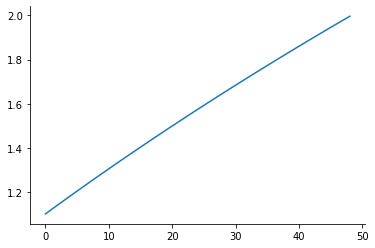

In [950]:
plt.plot(solu[1])

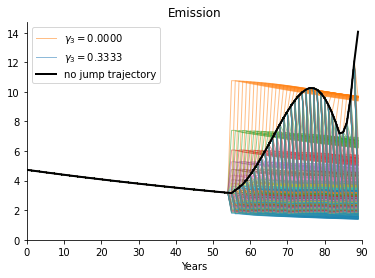

In [1023]:
solu[-2][1], 
ems_test = solu[-1]

color_palette = ["navy", "darkred", "darkorange", "forestgreen"]

for i in range(len(ems_test)):
    color_id = (i-1)%len(dmg_weight)
#     print(i, color_id, int((i-1)/len(dmg_weight)))
    name = ""
    if color_id == 0 and int((i-1)/len(dmg_weight))==0:
        name = "$\gamma_3 = {:.4f}$".format(γ3_list[color_id])
    elif color_id == len(dmg_weight)-1 and int((i-1)/len(dmg_weight))==1:
        name = "$\gamma_3 = {:.4f}$".format(γ3_list[color_id])
#     if color_id == 0 or color_id == 1:
    plt.plot(ems_test[i, :len(yt)], 
#              color=colors[color_id],
             alpha=0.5, label=name, linewidth=1)
# plt.plot(solu[0])
plt.plot(et, color="black", label="no jump trajectory", linewidth=2)
plt.ylim(0)
solu[-3][:,-1].sum()
# plt.plot(solu[-1].T)

plt.title("Emission")
plt.xlabel("Years")
plt.xlim(0, len(solu[0]))
plt.legend()
# plt.savefig("../figures/20_damages/emission_all_40.png",facecolor="w", edgecolor="w", dpi=500)

In [1016]:
ems_test.shape

(1561, 101)

IndexError: index 1401 is out of bounds for axis 0 with size 1401

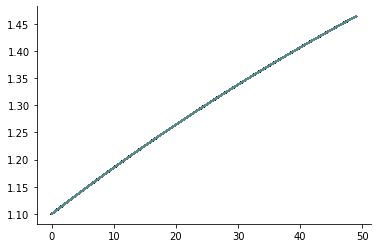

In [1017]:
for i in range(len(ems_test)):
    color_id = (i-1)%len(dmg_weight)
    name = ""
    if int((i-1)/len(dmg_weight)) == 35-1:
        name = "$\gamma_3 = {:.4f}$".format(γ3_list[color_id])
    plt.plot(solu[-2][i, :50], 
#              color=color_palette[color_id], 
             alpha=0.5, label=name)
plt.plot(yt, color="black", label="no jump trajectory", linewidth=2)
plt.title("Temperature anomaly")
plt.xlabel("Years")
plt.ylim(1.1, 3.2)
# plt.legend()
# plt.savefig("../figures/20_damages/tempanol_all.pdf", facecolor="w", edgecolor="w")

(1.1, 3.2)

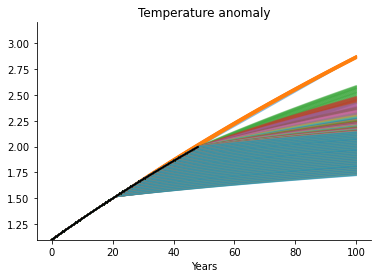

In [954]:
# 120
for i in range(len(ems_test)):
    color_id = (i-1)%len(dmg_weight)
    name = ""
    if int((i-1)/len(dmg_weight)) == 35-1:
        name = "$\gamma_3 = {:.4f}$".format(γ3_list[color_id])
    plt.plot(solu[-2][i, :120], 
#              color=color_palette[color_id], 
             alpha=0.5, label=name)
plt.plot(yt, color="black", label="no jump trajectory", linewidth=2)
plt.title("Temperature anomaly")
plt.xlabel("Years")
plt.ylim(1.1, 3.2)
# plt.legend()
# plt.savefig("../figures/20_damages/tempanol_all.pdf", facecolor="w", edgecolor="w")

In [955]:
np.interp(3, y_grid_cap, ems_ref[0])

9.625855283479735

In [956]:
np.sum(solu[-4][:, len(yt)-1])

1.0

(0.0, 1.05)

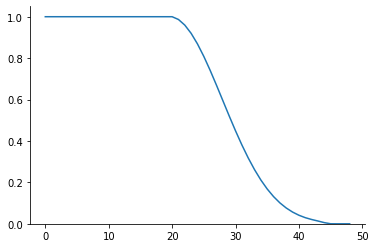

In [957]:
plt.plot(solu[3][:len(yt)])
plt.ylim(0)

In [958]:
solu[3]

array([1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 9.86620235e-01, 9.59498037e-01, 9.19647646e-01,
       8.68599778e-01, 8.08303932e-01, 7.41003829e-01, 6.69097170e-01,
       5.94992079e-01, 5.20972375e-01, 4.49082275e-01, 3.81038511e-01,
       3.18174484e-01, 2.61417578e-01, 2.11297411e-01, 1.67980150e-01,
       1.31322141e-01, 1.00935325e-01, 7.62570187e-02, 5.66175414e-02,
       4.13006355e-02, 2.95933207e-02, 2.08235674e-02, 1.34532022e-02,
       5.67198924e-03, 1.44171994e-04, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [959]:
solu[3], solu[-2][1], solu[-2][21], (1 - 0.99989311/0.99999407)/20
prob_test = solu[-4][:,89]

prob_test.sum()

1.0

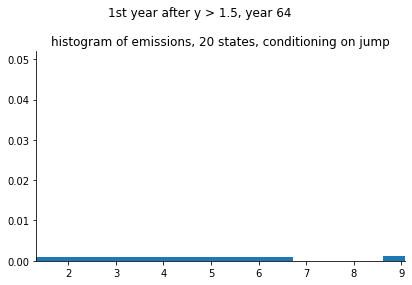

In [848]:
ems1 = solu[-1][:,65]
ems1 = ems1[np.nonzero(ems1)]
y1 = solu[-3][:,65]
y1 = y1[np.nonzero(y1)]
prob1 = solu[-2][:, 65]
prob1 = prob1[np.nonzero(prob1)]

fig, axes = plt.subplots(1,1, figsize=(6,4))
fig.suptitle("1st year after y > 1.5, year 64")
axes.bar(ems1[1:], height=prob1[1:]/np.sum(prob1[1:]))
axes.set_xlim(np.min(ems1), np.max(ems1))
# axes[1].bar(y1[1:], height=prob1[1:]/np.sum(prob1[1:]))


axes.set_title("histogram of emissions, 20 states, conditioning on jump")
# axes[1].set_title("histogram of temperature anomaly, 20 states")
fig.tight_layout()
axes.set_ylim(0, 0.052)
axes.set_xlim(np.min(ems1), np.max(ems1))
# plt.savefig("histogram_1.png", facecolor="w", edgecolor="w")
plt.show()

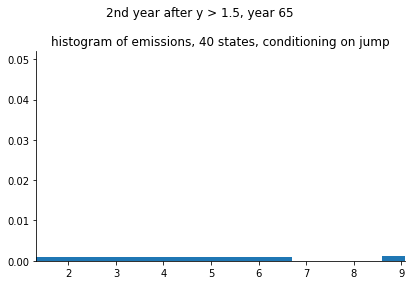

In [849]:
ems2 = solu[-1][:,66]
ems2 = ems2[np.nonzero(ems2)]
y2 = solu[-3][:, 66]
y2 = y2[np.nonzero(y2)]
prob2 = solu[-2][:, 66]
prob2 = prob2[np.nonzero(prob2)]

fig, axes = plt.subplots(1,1, figsize=(6,4))
fig.suptitle("2nd year after y > 1.5, year 65")
axes.bar(ems2[1:], height=prob2[1:]/np.sum(prob2[1:]))
# axes[0].set_xlim(np.)
# axes.bar(y2[1:], prob2[1:]/np.sum(prob2[1:]) )
axes.set_xlim(np.min(ems1), np.max(ems1))
axes.set_title("histogram of emissions, 40 states, conditioning on jump")
# axes.set_title("histogram of temperature anomaly, 41 states")
fig.tight_layout()
axes.set_ylim(0, 0.052)
# axes[1].set_xlim(1.5, 1.8)
# plt.savefig("histogram_2.png", facecolor="w", edgecolor="w")
plt.show()

In [850]:
len(yt)

49

In [858]:
t = len(yt)-1
ems_110 = solu[-1][:, t]
# ems_110 = ems_110[np.nonzero(ems_110)]
prob_110 = solu[-4][:, t]
# prob_110 = prob_110[np.nonzero(prob_110)]

y_110 = solu[-2][:,t]
# y_110 = y_110[np.nonzero(y_110)]

In [859]:
y_110[0], yt[-1], prob_110.sum()

(1.996596260163385, 1.996596260163385, 1.0)

In [860]:
bins[np.nonzero(distribution)]

array([1.45777348, 1.86827155, 2.27876963, 2.6892677 , 3.09976577,
       3.51026385, 3.92076192, 4.33126   , 4.74175807, 5.15225615,
       5.56275422, 6.38375037, 6.79424844, 8.84673882, 9.25723689])

In [861]:
prob_110.shape, ems_110.shape

((1121,), (1121,))

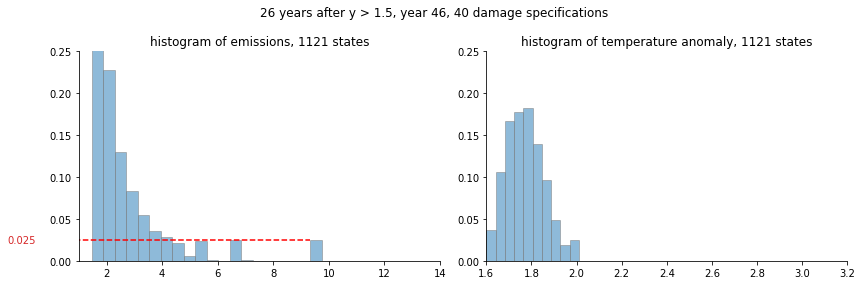

In [890]:
# bins=np.linspace(np.min(ems_110[1:]), np.max(ems_110[1:]), 20)
# delta_bin = bins[1] - bins[0]
# bins_y = np.linspace(np.min(y_110), np.max(y_110), 20)
t = 46
ems_110 = solu[-1][:, t]
# ems_110 = ems_110[np.nonzero(ems_110)]
prob_110 = solu[-4][:, t]
# prob_110 = prob_110[np.nonzero(prob_110)]

y_110 = solu[-2][:,t]
# y_110 = y_110[np.nonzero(y_110)]

fig, axes = plt.subplots(1,2, figsize=(12,4))
fig.suptitle("{:02d} years after y > 1.5, year {}, {} damage specifications".format(int((len(ems_110)-1)/len(dmg_weight))-2,t, len(dmg_weight)))
axes[0].hist(ems_110, weights=prob_110, bins=20, alpha=0.5, ec="gray")
axes[1].hist(y_110, weights=prob_110, bins=np.linspace(1.6, 3.2, 40), density=False, alpha=0.5, ec="gray")

trans = transforms.blended_transform_factory(
    axes[0].get_yticklabels()[0].get_transform(), axes[0].transData)

p = axes[0].patches

distribution = np.zeros(len(p))
for i in range(len(p)):
    distribution[i] = p[i].get_height()

bins = np.array([patch.get_xy()[0] for patch in p])
axes[0].hlines(distribution[-1], 0, bins[-1], color="red", linestyle="dashed")
axes[0].text(-0.1,distribution[-1], "{:.3f}".format(distribution[-1]), color="tab:red", transform=trans, 
        ha="right", va="center")
# no jump
# axes[0].hlines(distribution[np.nonzero(distribution)][-2], 0, bins[np.nonzero(distribution)][-2], color="green", linestyle="dashed")
# axes[0].text(-0.1,distribution[np.nonzero(distribution)][-2], "{:.3f} (no jump)".format(distribution[np.nonzero(distribution)][-2]), 
#              color="green", transform=trans, 
#         ha="right", va="center")
axes[0].set_xlim(1,14)
axes[1].set_xlim(1.6, 3.2)
axes[1].set_ylim(0,0.25)
axes[0].set_ylim(0,0.25)
# axes[1].annotate("No jump with probability .029",
#             xy=(y_110[0],0.025),xytext=(y_110[0]+0.1, 0.025),
#                 arrowprops=dict(facecolor='black', shrink=0.1, width=0.1, headwidth=3))
# axes[1].hlines(prob_110[0], xmin = np.min(y_110), xmax=np.max(y_110), linestyle="dashed", color="black")
axes[0].set_title("histogram of emissions, {} states".format(len(ems_110)))
axes[1].set_title("histogram of temperature anomaly, {} states".format(len(ems_110)))
fig.tight_layout()
# plt.savefig("histogram_new.png", dpi=500, facecolor="w", edgecolor="w")
# plt.show()

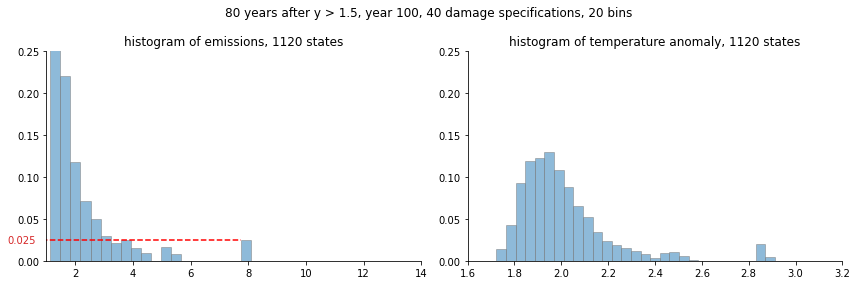

In [892]:
# bins=np.linspace(np.min(ems_110[1:]), np.max(ems_110[1:]), 20)
# delta_bin = bins[1] - bins[0]
# bins_y = np.linspace(np.min(y_110), np.max(y_110), 20)

t = 100
ems_110 = solu[-1][:, t]
# ems_110 = ems_110[np.nonzero(ems_110)]
prob_110 = solu[-4][:, t]
# prob_110 = prob_110[np.nonzero(prob_110)]

y_110 = solu[-2][:,t]
# y_110 = y_110[np.nonzero(y_110)]



fig, axes = plt.subplots(1,2, figsize=(12,4))
fig.suptitle("{:02d} years after y > 1.5, year {}, {} damage specifications, 20 bins".format(t-20, t, len(dmg_weight)))
axes[0].hist(ems_110[1:], weights=prob_110[1:], bins=20,ec="gray", alpha=0.5)
axes[1].hist(y_110[1:], weights=prob_110[1:], bins=np.linspace(1.6, 3.2, 40), ec="gray", alpha=0.5)

p = axes[0].patches
distribution = np.zeros(len(p))
for i in range(len(p)):
    distribution[i] = p[i].get_height()
bins = np.array([patch.get_xy()[0] for patch in p])

trans = transforms.blended_transform_factory(
    axes[0].get_yticklabels()[0].get_transform(), axes[0].transData)
axes[0].hlines(distribution[-1], 0, bins[-1], color="red", linestyle="dashed")
axes[0].text(-0.01,distribution[-1], "{:.3f}".format(distribution[-1]), color="tab:red", transform=trans, 
        ha="right", va="center")

axes[0].set_xlim(1,14)
axes[1].set_xlim(1.6,3.2)

axes[1].set_ylim(0,0.25)
axes[0].set_ylim(0,0.25)
# axes[1].annotate("No jump with probability .029",
#             xy=(y_110[0],0.025),xytext=(y_110[0]+0.1, 0.025),
#                 arrowprops=dict(facecolor='black', shrink=0.1, width=0.1, headwidth=3))
# axes[1].hlines(prob_110[0], xmin = np.min(y_110), xmax=np.max(y_110), linestyle="dashed", color="black")
axes[0].set_title("histogram of emissions, {} states".format(len(ems_110)-1))
axes[1].set_title("histogram of temperature anomaly, {} states".format(len(ems_110)-1))
fig.tight_layout()
# plt.savefig("histogram_new_100.png", dpi=500, facecolor="w", edgecolor="w")
# plt.show()

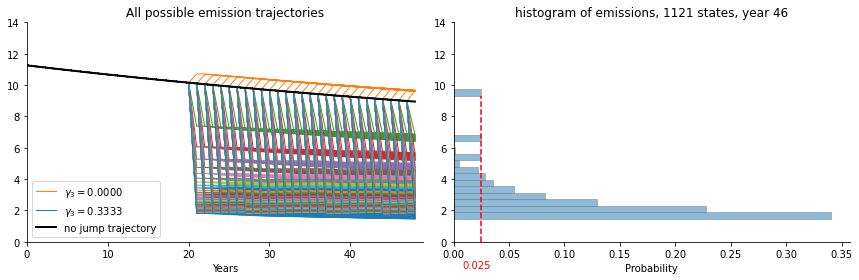

In [896]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12, 4)) 

t = 46
ems_110 = solu[-1][:, t]
# ems_110 = ems_110[np.nonzero(ems_110)]
prob_110 = solu[-4][:, t]
# prob_110 = prob_110[np.nonzero(prob_110)]

y_110 = solu[-2][:,t]
# y_110 = y_110[np.nonzero(y_110)]

for i in range(len(ems_test)):
    color_id = (i-1)%len(dmg_weight)
#     print(i, color_id, int((i-1)/len(dmg_weight)))
    name = ""
    if color_id == 0 and int((i-1)/len(dmg_weight))==0:
        name = "$\gamma_3 = {:.4f}$".format(γ3_list[color_id])
    elif color_id == len(dmg_weight)-1 and int((i-1)/len(dmg_weight))==1:
        name = "$\gamma_3 = {:.4f}$".format(γ3_list[color_id])
#     if color_id == 0 or color_id == 1:
    ax1.plot(ems_test[i, :len(yt)], 
#              color=colors[color_id],
             alpha=1, label=name, linewidth=1)
# ax1.plot(solu[0])
ax1.plot(et, color="black", label="no jump trajectory", linewidth=2)
ax1.set_ylim(0)

ax1.set_title("All possible emission trajectories")
ax1.set_xlabel("Years")
ax1.set_xlim(0, len(solu[0]))
ax1.legend()

# plot2


ax2.hist(ems_110, weights=prob_110, bins=20,
         alpha=0.5,
         orientation="horizontal", ec="gray")
trans = transforms.blended_transform_factory(
    ax2.get_yticklabels()[0].get_transform(), ax2.transData)

p = ax2.patches
distribution = np.zeros(len(p))
for i in range(len(p)):
    distribution[i] = p[i].get_width()
bins = np.array([patch.get_xy()[-1] for patch in p])

ax2.vlines(distribution[-1], 0, bins[-1], color="red", linestyle="dashed")
ax2.text(distribution[-1] + 0.05, -1.5, "{:.3f}".format(distribution[-1]), color="red", transform=trans, 
        ha="center", va="center")


# ax2.vlines(distribution[np.nonzero(distribution)][-2], -0.05, bins[np.nonzero(distribution)][-2], color="green", linestyle="dashed")
# ax2.text(distribution[np.nonzero(distribution)][-2]+0.03, -2.2, 
#          "{:.3f} (no jump)".format(distribution[np.nonzero(distribution)][-2]), 
#              color="green", transform=trans, 
#         ha="center", va="center")

# ax2.set_xlim(1,14)
ax2.set_ylim(0,14)
ax1.set_ylim(0,14)
# axes[1].annotate("No jump with probability .029",
#             xy=(y_110[0],0.025),xytext=(y_110[0]+0.1, 0.025),
#                 arrowprops=dict(facecolor='black', shrink=0.1, width=0.1, headwidth=3))
# axes[1].hlines(prob_110[0], xmin = np.min(y_110), xmax=np.max(y_110), linestyle="dashed", color="black")
ax2.set_title("histogram of emissions, {} states, year 46".format(len(ems_110)))
ax2.set_xlabel("Probability")
fig.subplots_adjust(wspace=-1)
fig.tight_layout()
plt.savefig("../figures/20_damages/emission_hist_new.png",facecolor="w", edgecolor="w", dpi=500)

In [296]:
p[-1].get_xy(), distribution

((0.0, 12.929800423113878),
 array([0.3861962 , 0.26626446, 0.12782639, 0.06918306, 0.04149067,
        0.02715704, 0.0226795 , 0.00243144, 0.02358719, 0.00115756,
        0.        , 0.        , 0.        , 0.02481983, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.00720666]))

In [616]:
prob_110.shape, ems_110.shape

((1120,), (1121,))

In [172]:
indices_mat = np.zeros((len(dmg_weight), int( (len(ems_110)-1)/len(dmg_weight))), dtype=int)
prob = np.
for i in range(len(dmg_weight)):
    count = 0
    for j in range(1,len(ems_110)):
        if (j-1)%len(dmg_weight) == i:
            indices_mat[i,count] = j
            count += 1

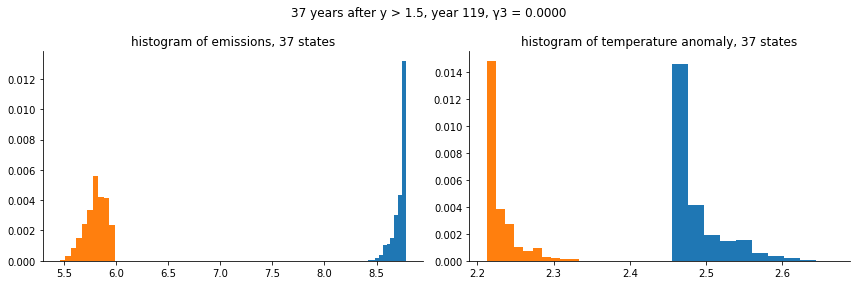

In [192]:
# bins=np.linspace(np.min(ems_110[1:]), np.max(ems_110[1:]), 20)
# delta_bin = bins[1] - bins[0]
# bins_y = np.linspace(np.min(y_110), np.max(y_110), 20)

i = 0
fig, axes = plt.subplots(1,2, figsize=(12,4))
fig.suptitle("{:02d} years after y > 1.5, year {}, γ3 = {:.4f}".format(int((len(ems_110)-1)/len(dmg_weight)),len(yt)-1, γ3_list[i]))
axes[0].hist(ems_110[indices_mat[i]], weights=prob_110[indices_mat[i]], bins=10)
axes[0].hist(ems_110[indices_mat[i+1]], weights=prob_110[indices_mat[i+1]], bins=10)
axes[1].hist(y_110[indices_mat[i]], weights=prob_110[indices_mat[i]], bins=10, density=False)
axes[1].hist(y_110[indices_mat[i+1]], weights=prob_110[indices_mat[i+1]], bins=10, density=False)
# axes[1].annotate("No jump with probability .029",
#             xy=(y_110[0],0.025),xytext=(y_110[0]+0.1, 0.025),
#                 arrowprops=dict(facecolor='black', shrink=0.1, width=0.1, headwidth=3))
# axes[1].hlines(prob_110[0], xmin = np.min(y_110), xmax=np.max(y_110), linestyle="dashed", color="black")
axes[0].set_title("histogram of emissions, {} states".format(len(ems_110[indices_mat[i]])))
axes[1].set_title("histogram of temperature anomaly, {} states".format(len(ems_110[indices_mat[i]])))
fig.tight_layout()
# plt.savefig("histogram_{}_tight.png".format(i), facecolor="w", edgecolor="w", dpi=500)
# plt.show()

In [ ]:
np.abs(distribution).argmax()

In [ ]:
bins[2], bins[3]

In [ ]:
in_the_bin = np.where((ems_110 >= bins[2] )& (ems_110 < bins[3]))[0]

In [ ]:
(in_the_bin-1)/40

In [ ]:
y_110_1 = y_110[1:]
y_large = y_110_1[y_110_1>=1.95]
y_small = y_110_1[y_110_1<1.95]


ems_110_1 = ems_110[1:]
ems_large = ems_110_1[y_110_1>=1.95]
ems_small = ems_110_1[y_110_1<1.95]
prob_110_1 = prob_110[1:]
prob_large = prob_110_1[y_110_1 >= 1.95]
prob_small = prob_110_1[y_110_1 < 1.95]

In [ ]:
prob_large.argmax(), prob_large[30:33], y_large[30:33]

In [ ]:
plt.bar(y_large, prob_large, width=0.005)

In [ ]:
np.where(solu[-3][:,110] ==  y_large[31])[0][0]

In [ ]:
(1241-1)/40

In [ ]:
yt[-1], y_110[1121]

In [ ]:
prob_small.argmax(), prob_small[1209], y_small[1209]

In [ ]:
plt.figure(figsize=(10,4))
plt.bar(y_small, prob_small, width=0.005, color="tab:blue", alpha=0.1)
plt.bar(y_small[1209:1209+39], prob_small[1209:1209+39], color="black", width=0.002, label="peaks")

plt.bar(y_large, prob_large, width=0.004, color="tab:red", alpha=0.5)
plt.bar(y_large[31], prob_large[31], width=0.005, color="black")
plt.hlines(prob_small[1209], xmin=np.min(y_110), xmax=np.max(y_110), linestyle="dashed", color="black")

plt.annotate("Jump occurs 31 years after y > 1.5,\n to each damage specification with probability .00107",
            xytext=(2.1,0.001-0.001/5), xy=(2.1, prob_large[31]),
            arrowprops=dict(facecolor='black', shrink=0.1, width=0.1, headwidth=3))

plt.annotate("Lowest damage specification ($\gamma_3^m = 0$)",
            xy=(y_large[31],0.001/2), xytext=(y_large[31]+0.1,0.001/2), 
            arrowprops=dict(facecolor='black', shrink=0.1, width=0.1, headwidth=3),)

plt.title('Temperature anomaly')
plt.ylabel("Probability")
plt.legend(loc=(0.01,0.8))
plt.tight_layout()
# plt.savefig("../figures/20_damages/tempanol_46.pdf", facecolor="w", edgecolor="w")

In [ ]:
plt.figure(figsize=(10,4))
plt.bar(ems_small, prob_small, width=0.05, color="tab:blue", alpha=0.1)
plt.bar(ems_small[1209:1209+39], prob_small[1209:1209+39], color="black", width=0.01, label="peaks")

plt.bar(ems_large, prob_large, width=0.01, color="tab:red", alpha=0.5)
plt.bar(ems_large[31], prob_large[31], width=0.05, color="black")
plt.hlines(prob_small[1209], xmin=np.min(ems_110), xmax=np.max(ems_110), linestyle="dashed", color="black")

plt.annotate("Jump occurs 31 years after y > 1.5,\n to each damage specification with probability .00107",
            xytext=(10,prob_large[31]-0.0002),
            xy=(10,prob_large[31]),
            arrowprops=dict(facecolor='black', shrink=0.1, width=0.1, headwidth=3))

plt.annotate("Lowest damage specification",
            xy=(ems_large[31],0.001/2), xytext=(ems_large[31]+ 1,0.001/2), 
            arrowprops=dict(facecolor='black', shrink=0.1, width=0.1, headwidth=3),)

plt.title('Emissions')
plt.ylabel('Probability')
plt.legend(loc=(0.8,0.1), frameon=False)
plt.tight_layout()
# plt.savefig("../figures/20_damages/ems_46.pdf", facecolor="w", edgecolor="w")

In [ ]:
1/40

In [ ]:
np.where(solu[-3][:,110] ==  y_small[1209])[0][0]

In [ ]:
(1242-1)/40

In [ ]:
prob_110[31*40+1:32*40+2], prob_small[1209:1209+40]

In [ ]:
plt.plot(intensity)

In [ ]:
indice_ems = np.argsort(ems_110_1)
ems_sort = ems_110_1[indice_ems]
prob_sort = prob_110_1[indice_ems]

In [ ]:
@njit
def simulate_ems(y_grid_cap, ems_pre, ems_ref, θ, y_start =1.1,  T=86, dt=1):
    tspan  = int(T/dt)
    ems_grid_realize = ems_pre
    et = np.zeros(tspan)
    yt = np.zeros(tspan)
    state_t = np.zeros(tspan)
    y = y_start
    # flag
    jumped = False
    for t in range(tspan):
        if y < y_lower:
            e_i = np.interp(y, y_grid_cap, ems_grid_realize)
            et[t] = e_i
            yt[t] = y
            state_t[t] = 0
            y = y + e_i*θ
            
        elif y >= y_lower and jumped == False:
#             print(t)
            intensity_i = r0*(np.exp(r1/2*(y-y_lower)**2) - 1)
            jump = np.random.binomial(1, intensity_i)
            if jump == 1:
                jumped = True
                dmg_realization = np.random.multinomial(1, pvals=dmg_weight)
                loc = np.abs(y-jump_interval).argmin()
                damage_type = np.argwhere(dmg_realization==1)
                ems_grid_realize = ems_list[loc, damage_type[0][0]]
                state_t[t] = 1 + damage_type[0][0]
                et[t] = np.interp(y, y_grid, ems_grid_realize)
            elif jump == 0:
                et[t] = np.interp(y, y_grid_cap, ems_grid_realize)
                state_t[t] = 0
            yt[t] = y
            y = y + et[t]*θ
        elif y>=y_lower and jumped  == True:
            et[t] = np.interp(y, y_grid, ems_grid_realize)
            state_t[t] = state_t[t-1]
            yt[t] = y
            y = y + et[t]*θ
    return yt, et, state_t

In [ ]:
@njit
def simulate_path(y_grid_cap, ems_pre, ems_ref, θ, T, N=1_000_000):
    Yt = np.zeros((N, T))
    Et = np.zeros((N, T))
    Statet = np.zeros((N, T))
    for s in range(N):
        np.random.seed(s)
        yt, et, state_t = simulate_ems(y_grid_cap, ems_pre, ems_ref, θ, T=T)
        Yt[s] = yt
        Et[s] = et
        Statet[s] = state_t
    return Yt, Et, Statet

In [ ]:
Yt, Et, Statet = simulate_path(y_grid_cap, solution['ems'], ems_ref, np.mean(θ_list), len(yt))

In [ ]:
et_100 = Et[:,len(yt)-1]
yt_100 = Yt[:,len(yt)-1]

In [ ]:
plt.hist(yt_100, weights =np.ones_like(yt_100)/len(yt_100),  bins=50)
plt.show()

In [ ]:
plt.hist(et_100, weights =np.ones_like(et_100)/len(et_100),  bins=50)
plt.show()

In [ ]:
Yt[:,-1]

In [ ]:
for i in range(len(Et)):
    plt.plot(Et[i])
plt.show()

In [ ]:
len(et_100[et_100==0])

In [ ]:
np.unique(et_100).shape

In [ ]:
np.unique(yt_100[Statet[:,-1]==20]).shape, np.unique(yt_100[Statet[:,-1]==10]).shape

In [ ]:
np.median(γ3_list)

In [ ]:
# emission
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,4))
fig.suptitle("emission histogram for two of the $\gamma_3$, year 100")
ax1.hist(et_100[Statet[:,78]==4], 
         bins=20, weights=np.ones(len(et_100[Statet[:,78]==4]))/len(et_100[Statet[:,78]==4]))
ax1.set_ylim(0,0.14)
ax1.set_title("γ3 = 0, 35 states")
# ax1.set_xlim(1.2,1.72)
ax2.hist(yt_100[Statet[:,78]==4], 
         bins=20, weights=np.ones(len(yt_100[Statet[:,78]==4]))/len(yt_100[Statet[:,78]==4]))
ax2.set_ylim(0,0.14)
ax2.set_title('γ3 = 0.7706 (extreme damage), 35 states')
fig.tight_layout()
# plt.savefig('histogram_e.pdf')

In [ ]:
# Y
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,4))
fig.suptitle("temperature anomaly histogram for two of the $\gamma_3$, year 100")
ax1.hist(yt_100[Statet[:,-1]==10], 
         bins=20, weights=np.ones(len(yt_100[Statet[:,-1]==10]))/len(yt_100[Statet[:,-1]==10]))
ax1.set_ylim(0,0.14)
ax1.set_title("γ3 = 0.3650, 35 states")
# ax1.set_xlim(1.2,1.72)
ax2.hist(yt_100[Statet[:,-1]==20], 
         bins=20, weights=np.ones(len(yt_100[Statet[:,-1]==20]))/len(yt_100[Statet[:,-1]==20]))
ax2.set_ylim(0,0.14)
ax2.set_title('γ3 = 0.7706 (extreme damage), 35 states')
fig.tight_layout()
# plt.savefig('histogram_y.pdf')

In [ ]:
plt.hist(et_100[Statet[:,-1]==10])

In [ ]:
plt.hist(Yt[:,-1], bins=100, density=False)
plt.show()

In [ ]:
len(np.unique(Et[:,-1]))

In [ ]:
e_select = Et[np.where(Statet[:, 60]==), 80]

In [ ]:
weights = np.ones_like(e_select.flatten()) / len(e_select.flatten())
plt.hist(e_select.flatten(), weights=weights, bins=20)

In [ ]:
et_10 = np.percentile(Et, 10, axis=0)
et_50 = np.percentile(Et, 50, axis=0)
et_90 = np.percentile(Et, 90, axis=0)

In [ ]:
plt.plot(et_10, label='.1 percentile')
plt.plot(et_50, label='.5 percentile')
plt.plot(et_90, label='.9 percentile')
plt.plot(et_10[:50])
plt.vlines(50, ymin=0, ymax=np.max(et_90), color="black", linestyle="dashed")
plt.ylim(0)
plt.title('Emission')